# 0. Importar bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
import time
from datetime import datetime

# 1. Entendimento do Negócio


A RetaiX emprega cerca de 4000 funcionários. No entanto, todos os anos, cerca de 15% de seus funcionários deixam a empresa e precisam ser substituídos por novos funcionários que estão disponíveis no mercado. A gestão acredita que esse nível de rotatividade (funcionários saindo, seja por vontade própria ou porque foram demitidos) é ruim para a empresa, pelos seguintes motivos:

Dificuldade no cumprimento dos prazos, resultando em perda de reputação entre consumidores e parceiros.
Um departamento considerável precisa ser mantido para fins de recrutamento de novos talentos.
Na maioria das vezes, os novos funcionários precisam ser treinados para o trabalho e/ou precisam de tempo para se ambientarem à empresa.
Por outro lado, a RetailX também percebeu que poderia melhorar o relacionamento com os clientes, por meio do entendimento do comportamento de compra deles. A empresa possui dados de campanhas, compras, cadastro e até da renda de cada cliente.

Diante deste cenário a empresa decidiu investir em dois projetos:
* Projeto de RH;
* Projeto de CRM.

Neste momento, focaremos no Projeto de CRM. A seguir estão dispostas as demandas:
* Encontrar personas no grupo de clientes para identificar padrões de comportamento;
* Analisar cada persona e verificar se existem ações que podem ser feitas para melhorar a relação com os clientes;
* Gerar um relatório com as conclusões para que o gestor do CRM possa tomar as devidas providências para que a empresa aumente o faturamento, reduze o custos com campanhas e melhore o relacionamento com os clientes.

# 2. Entendimento dos Dados


## 2.1 Leitura da Base de Público


In [ ]:
df_publico = pd.read_csv('/content/tb_crm_clientes.csv')
df_publico.head()

,IDCliente,AnoDeNascimento,NivelDeEducacao,EstadoCivil,RendaAnualFamiliar,QtdDeCriancasNaCasa,QtdDeAdolescentesNaCasa,DataDeInscricao,DiasDesdeUltimaCompra,GastoComVinhoNosUltimos2Anos,...,VisitasAoSiteNoUltimoMes,AceitouCampanha3,AceitouCampanha4,AceitouCampanha5,AceitouCampanha1,AceitouCampanha2,ReclamouNosUltimos2Anos,IndicadorCustoContato,IndicadorDeReceita,AceitouUltimaCampanha
0,5524,1957,Graduação,Solteiro(a),58138.0,0,0,2021-04-09,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduação,Solteiro(a),46344.0,1,1,2023-08-03,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduação,União Estável,71613.0,0,0,2022-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduação,União Estável,26646.0,1,0,2023-10-02,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,Doutorado,Casado(a),58293.0,1,0,2023-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


## 2.2 Análise da Base do Estudo

Nesse primeiro momento, analisa-se os tipos de cada variável assim como preenchimento e cardinalidade.


In [ ]:
# Metadados referente ao conjunto de dados
def pod_academy_generate_metadata(dataframe):
    """
    Gera um dataframe contendo metadados das colunas do dataframe fornecido.

    :param dataframe: DataFrame para o qual os metadados serão gerados.
    :return: DataFrame contendo metadados.
    """

    # Coleta de metadados básicos
    metadata = pd.DataFrame({
        'nome_variavel': dataframe.columns,
        'tipo': dataframe.dtypes,
        'qt_nulos': dataframe.isnull().sum(),
        'percent_nulos': round((dataframe.isnull().sum() / len(dataframe))* 100,2),
        'cardinalidade': dataframe.nunique(),
    })
    metadata=metadata.sort_values(by='percent_nulos',ascending=False)
    metadata = metadata.reset_index(drop=True)

    return metadata

In [ ]:
pod_academy_generate_metadata(df_publico)

,nome_variavel,tipo,qt_nulos,percent_nulos,cardinalidade
0,RendaAnualFamiliar,float64,24,1.07,1974
1,IDCliente,int64,0,0.00,2240
2,ComprasComDesconto,int64,0,0.00,15
3,IndicadorDeReceita,int64,0,0.00,1
4,IndicadorCustoContato,int64,0,0.00,1
5,ReclamouNosUltimos2Anos,int64,0,0.00,2
6,AceitouCampanha2,int64,0,0.00,2
7,AceitouCampanha1,int64,0,0.00,2
8,AceitouCampanha5,int64,0,0.00,2
9,AceitouCampanha4,int64,0,0.00,2


### 2.2.1 Estatística Descritiva

In [ ]:
df_publico.describe()

,IDCliente,AnoDeNascimento,RendaAnualFamiliar,QtdDeCriancasNaCasa,QtdDeAdolescentesNaCasa,DiasDesdeUltimaCompra,GastoComVinhoNosUltimos2Anos,GastoComFrutasNosUltimos2Anos,GastoComCarneNosUltimos2Anos,GastoComPeixeNosUltimos2Anos,...,VisitasAoSiteNoUltimoMes,AceitouCampanha3,AceitouCampanha4,AceitouCampanha5,AceitouCampanha1,AceitouCampanha2,ReclamouNosUltimos2Anos,IndicadorCustoContato,IndicadorDeReceita,AceitouUltimaCampanha
count,2240.000000,2240.000000,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,...,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.0,2240.0,2240.000000
mean,5592.159821,1968.805804,52247.251354,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,...,5.316518,0.072768,0.074554,0.072768,0.064286,0.013393,0.009375,3.0,11.0,0.149107
std,3246.662198,11.984069,25173.076661,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,...,2.426645,0.259813,0.262728,0.259813,0.245316,0.114976,0.096391,0.0,0.0,0.356274
min,0.000000,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
25%,2828.250000,1959.000000,35303.000000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
50%,5458.500000,1970.000000,51381.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,...,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
75%,8427.750000,1977.000000,68522.000000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,...,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
max,11191.000000,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,...,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.0,11.0,1.000000


### 2.2.2 Volume da Base


Percebe-se pela análise do metadados que a variável que identificada cada cliente (IDCliente) possui 2240 entradas e nenhum missing. Dessa forma, nota-se que o volume da base é 2240 clientes.

### 2.2.3 Taxa de aceitação (Cliente que aceitou a última campanha)


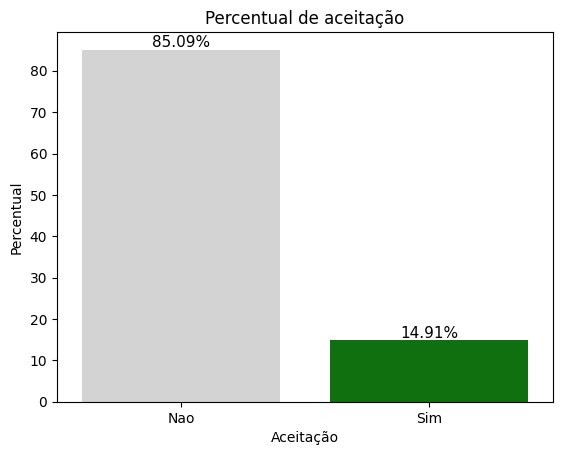

In [ ]:
aceitacao_counts = df_publico['AceitouUltimaCampanha'].value_counts()

# Calculando os percentuais de aceitacao
percent_nao = (aceitacao_counts[0] / len(df_publico)) * 100
percent_sim = (aceitacao_counts[1] / len(df_publico)) * 100

# Criando o DataFrame total_by_aceitacao
total_by_aceitacao = pd.DataFrame({'AceitouUltimaCampanha': ['Nao', 'Sim'], 'Percent': [percent_nao, percent_sim]})

# Definindo as cores
cores = {'Nao': 'lightgrey', 'Sim': 'green'}

# Plotando o gráfico de barras com seaborn
ax = sns.barplot(x='AceitouUltimaCampanha', y='Percent', hue='AceitouUltimaCampanha', data=total_by_aceitacao, palette=cores, dodge=False)

# Adicionando os valores de cada barra com símbolo de porcentagem
for p in ax.patches:
    ax.annotate("{:.2f}%".format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.xlabel('Aceitação')
plt.ylabel('Percentual')
plt.title('Percentual de aceitação')
plt.show()

Verifica-se que a taxa de aceitação da última campanha nesta base é 14,91%.


### 2.2.4 Distribuição de Renda Anual Familiar e Taxa de aceitação por Faixa de Renda Anual Familiar (Cliente que aceitou a última campanha)

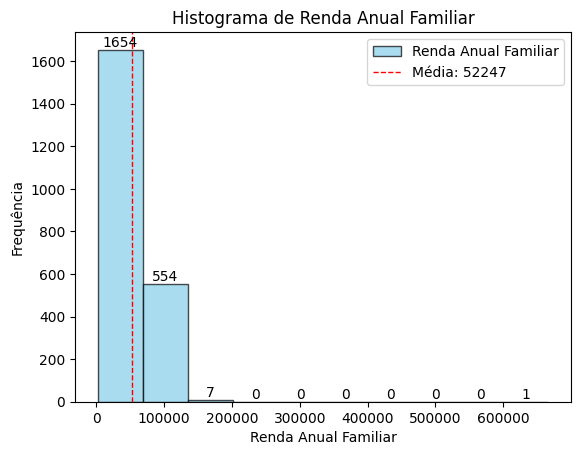

In [ ]:
# Plotando o histograma das idades
hist, bins, _ = plt.hist(df_publico['RendaAnualFamiliar'], bins=10, color='skyblue', edgecolor='black', alpha=0.7, label='Renda Anual Familiar')

# Calculando a média das idades
media_renda = df_publico['RendaAnualFamiliar'].mean()

# Adicionando a linha vertical para a média
plt.axvline(media_renda, color='red', linestyle='dashed', linewidth=1)
plt.legend(['Renda Anual Familiar', 'Média: {:.0f}'.format(media_renda)], loc='upper right')

# Adicionando os valores da frequência em cada barra
for i in range(len(hist)):
    plt.text(bins[i] + (bins[i+1] - bins[i]) / 2, hist[i], str(int(hist[i])), ha='center', va='bottom')

# Configurando os rótulos e título
plt.xlabel('Renda Anual Familiar')
plt.ylabel('Frequência')
plt.title('Histograma de Renda Anual Familiar')

# Mostrando o gráfico
plt.show()

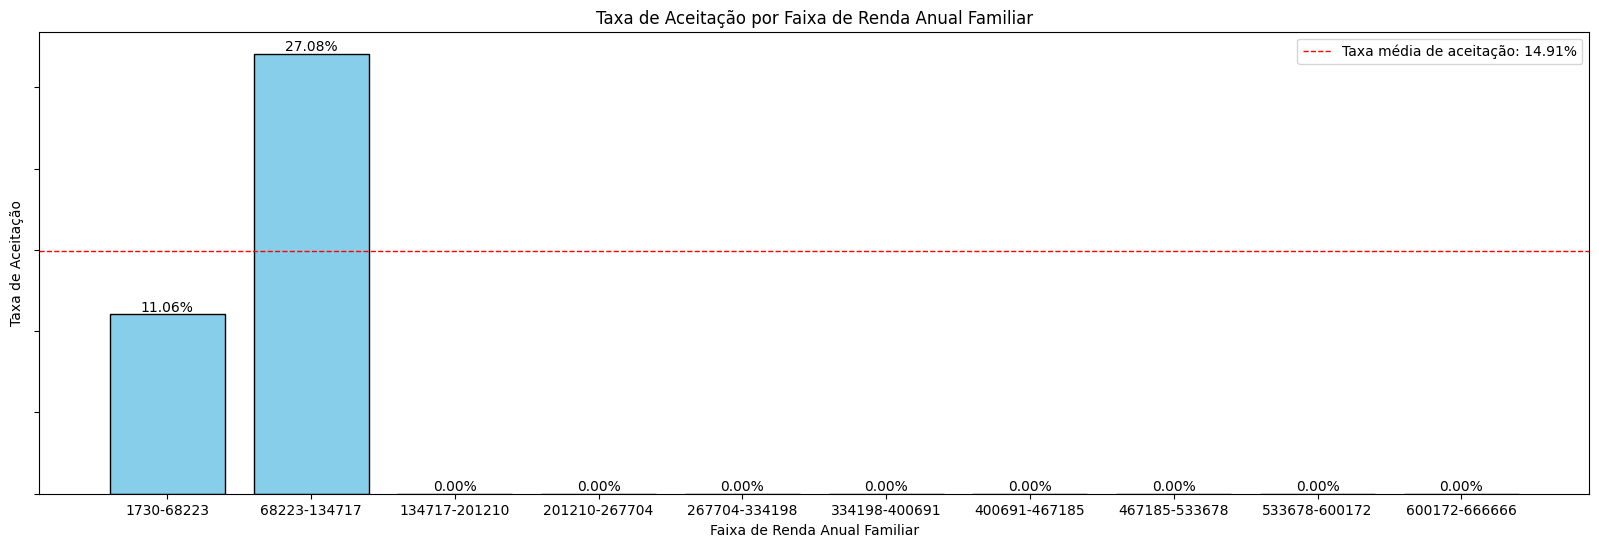

In [ ]:
taxa_aceitacao_por_faixa = []
for i in range(len(bins)-1):
    faixa_inferior = bins[i]
    faixa_superior = bins[i+1]
    taxa_aceitacao = df_publico[(df_publico['RendaAnualFamiliar'] >= faixa_inferior) & (df_publico['RendaAnualFamiliar'] < faixa_superior)]['AceitouUltimaCampanha'].value_counts(normalize=True).get(1, 0)
    taxa_aceitacao_por_faixa.append(taxa_aceitacao)

# Calculando a média da variável de aceitacao
taxa_media_aceitacao = df_publico['AceitouUltimaCampanha'].value_counts(normalize=True).get(1, 0)

# Plotando o gráfico de barras
plt.figure(figsize=(20,6))
plt.bar(range(len(bins)-1), taxa_aceitacao_por_faixa, color='skyblue', edgecolor='black')

# Adicionando os valores das taxas de aceitacao nas barras
for i, taxa in enumerate(taxa_aceitacao_por_faixa):
    plt.text(i, taxa, '{:.2f}%'.format(taxa * 100), ha='center', va='bottom', fontsize=10)

# Adicionando uma linha indicando a média da variável de aceitacao
plt.axhline(taxa_media_aceitacao, color='red', linestyle='dashed', linewidth=1, label='Taxa média de aceitação: {:.2f}%'.format(taxa_media_aceitacao * 100))

# Adicionando as faixas de idade no eixo x
plt.xticks(range(len(bins)-1), ['{}-{}'.format(int(faixa_inf), int(faixa_sup)) for faixa_inf, faixa_sup in zip(bins[:-1], bins[1:])])

plt.gca().axes.yaxis.set_ticklabels([])

# Adicionando rótulos e título
plt.xlabel('Faixa de Renda Anual Familiar')
plt.ylabel('Taxa de Aceitação')
plt.title('Taxa de Aceitação por Faixa de Renda Anual Familiar')

# Adicionando a legenda
plt.legend()

# Mostrando o gráfico
plt.show()

Nota-se que:
* A maior parte dos clientes (aproximadamente 74%) tem uma renda familiar anual de até 68223 unidades monetárias;
* Quase não há clientes com renda familiar anual maior que 134717 unidades monetárias;
* A faixa de 68223 a 134717 unidades monetárias, correspondente a 24,73% do público, apresenta uma taxa de aceitação bem acima das demais faixas.

### 2.2.5 Quantidade de Clientes por Nível de Educação e Taxa de aceitação por Nível de Educação (Cliente que aceitou a última campanha)

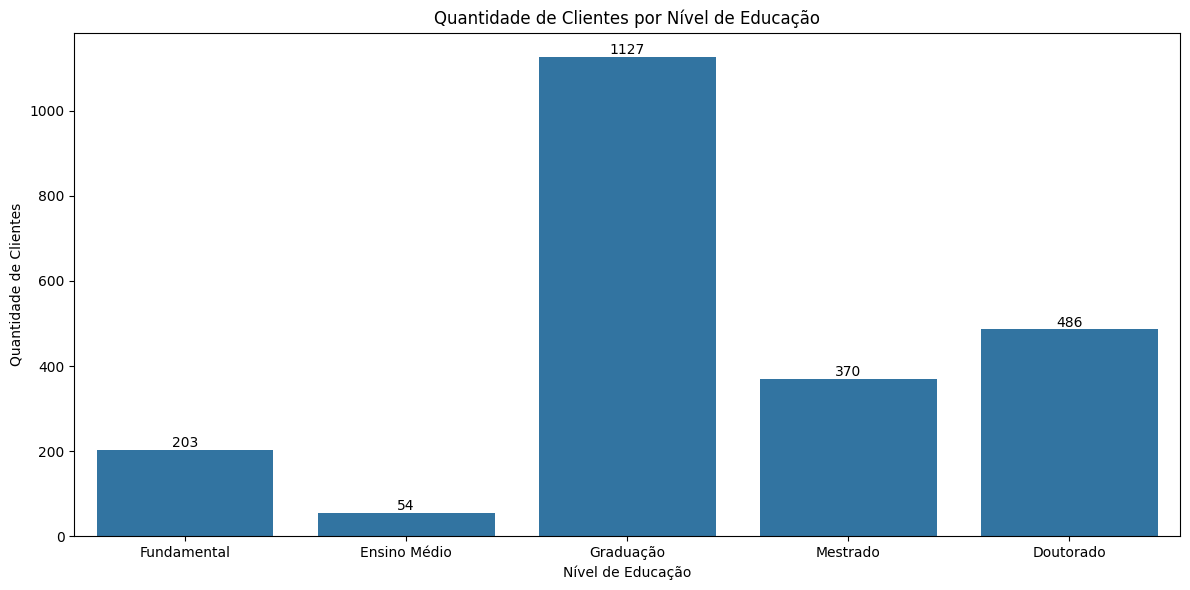

In [ ]:
# Definindo a ordem das categorias
ordem_educacao = ['Fundamental', 'Ensino Médio', 'Graduação', 'Mestrado', 'Doutorado']

# Contando as ocorrências de cada categoria na variável 'NivelDeEducacao' e ordenando em ordem decrescente
funcao_counts = df_publico['NivelDeEducacao'].value_counts().reindex(ordem_educacao)

plt.figure(figsize=(12, 6))

# Plotando o gráfico de barras com seaborn e deixando o Seaborn gerenciar as cores
ax = sns.countplot(x='NivelDeEducacao', data=df_publico, order=ordem_educacao)

# Adicionando os valores de cada barra
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.xlabel('Nível de Educação')
plt.ylabel('Quantidade de Clientes')
plt.title('Quantidade de Clientes por Nível de Educação')
plt.tight_layout()
plt.show()

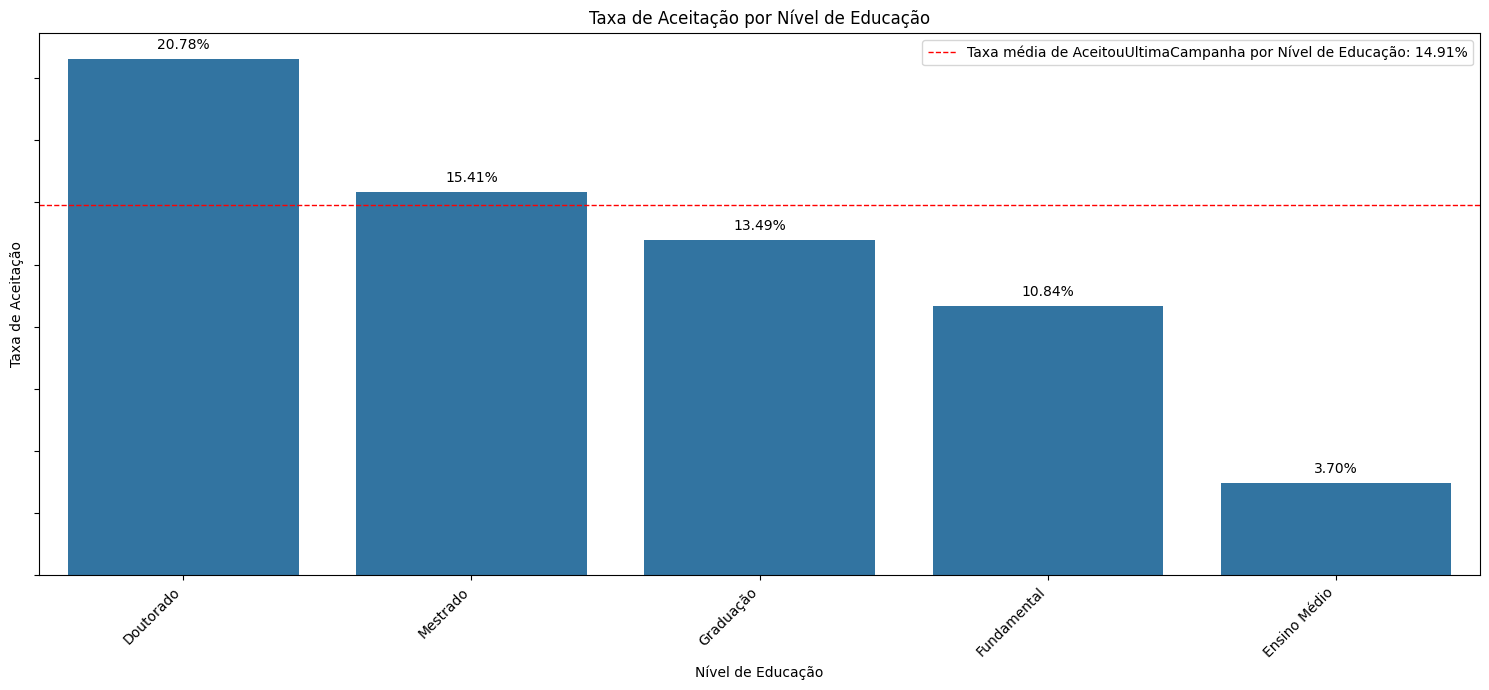

In [ ]:
# Calculando a taxa de aceitacao para cada função
taxa_aceitacao_por_funcao = df_publico.groupby('NivelDeEducacao')['AceitouUltimaCampanha'].apply(lambda x: (x == 1).mean())

# Ordenando as funções por taxa de aceitacao
funcoes_ordenadas = taxa_aceitacao_por_funcao.sort_values(ascending=False)

plt.figure(figsize=(15,7))

# Plotando o gráfico de barras com cor azul
ax = sns.barplot(x=funcoes_ordenadas.index, y=funcoes_ordenadas.values)

# Adicionando os valores de cada barra
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(p.get_height() * 100), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.gca().axes.yaxis.set_ticklabels([])

# Adicionando uma linha indicando a taxa média de Aceitação
taxa_media_aceitacao_funcao = df_publico['AceitouUltimaCampanha'].value_counts(normalize=True).get(1, 0)
plt.axhline(taxa_media_aceitacao_funcao, color='red', linestyle='dashed', linewidth=1, label='Taxa média de AceitouUltimaCampanha por Nível de Educação: {:.2f}%'.format(taxa_media_aceitacao_funcao * 100))

plt.xlabel('Nível de Educação')
plt.ylabel('Taxa de Aceitação')
plt.title('Taxa de Aceitação por Nível de Educação')
plt.xticks(rotation=45, ha='right')  # Rotaciona os rótulos do eixo x para melhor visualização
plt.tight_layout()  # Ajusta o layout para evitar sobreposição de elementos

# Adicionando a legenda
plt.legend()

plt.show()

Observa-se que:
* 50% dos clientes possuem como nível de educação máximo a graduação;
* 88,5% dos clientes possuem pelo menos o ensino superior;
* O público que possui doutorado foi o que possuiu maior taxa de aceitação de pelo menos alguma campanha ofertada.

### 2.2.6 Quantidade de Clientes por Estado Civil e Taxa de aceitação por Estado Civil (Cliente que aceitou a última campanha)

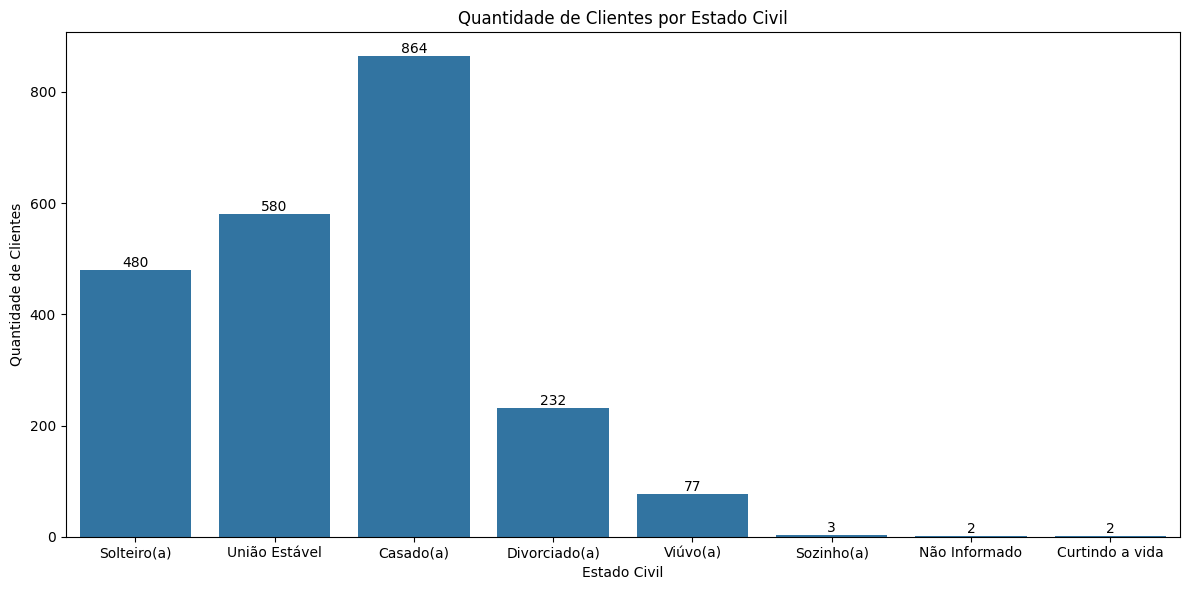

In [ ]:
plt.figure(figsize=(12, 6))

# Plotando o gráfico de barras com seaborn e deixando o Seaborn gerenciar as cores
ax = sns.countplot(x='EstadoCivil', data=df_publico)

# Adicionando os valores de cada barra
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.xlabel('Estado Civil')
plt.ylabel('Quantidade de Clientes')
plt.title('Quantidade de Clientes por Estado Civil')
plt.tight_layout()
plt.show()

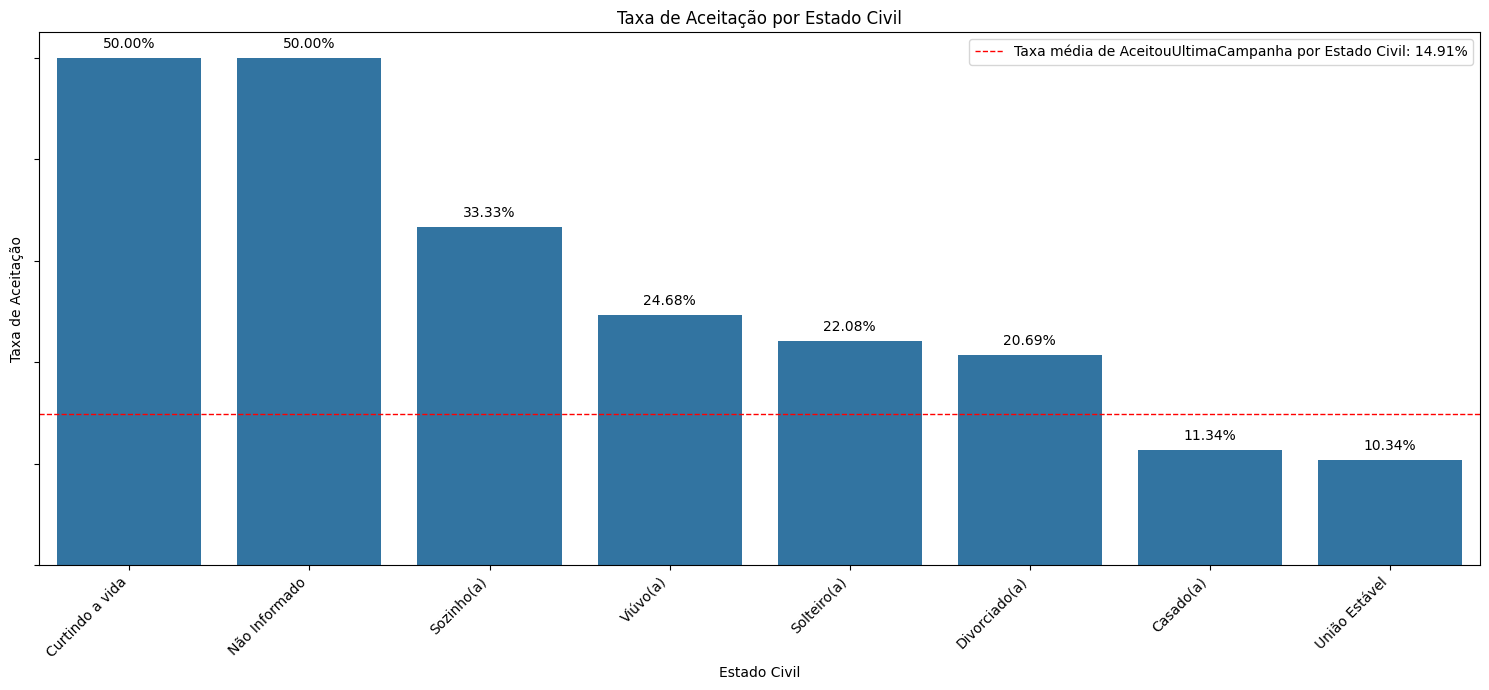

In [ ]:
# Calculando a taxa de aceitacao para cada função
taxa_aceitacao_por_funcao = df_publico.groupby('EstadoCivil')['AceitouUltimaCampanha'].apply(lambda x: (x == 1).mean())

# Ordenando as funções por taxa de aceitacao
funcoes_ordenadas = taxa_aceitacao_por_funcao.sort_values(ascending=False)

plt.figure(figsize=(15,7))

# Plotando o gráfico de barras com cor azul
ax = sns.barplot(x=funcoes_ordenadas.index, y=funcoes_ordenadas.values)

# Adicionando os valores de cada barra
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(p.get_height() * 100), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.gca().axes.yaxis.set_ticklabels([])

# Adicionando uma linha indicando a taxa média de Aceitação
taxa_media_aceitacao_funcao = df_publico['AceitouUltimaCampanha'].value_counts(normalize=True).get(1, 0)
plt.axhline(taxa_media_aceitacao_funcao, color='red', linestyle='dashed', linewidth=1, label='Taxa média de AceitouUltimaCampanha por Estado Civil: {:.2f}%'.format(taxa_media_aceitacao_funcao * 100))

plt.xlabel('Estado Civil')
plt.ylabel('Taxa de Aceitação')
plt.title('Taxa de Aceitação por Estado Civil')
plt.xticks(rotation=45, ha='right')  # Rotaciona os rótulos do eixo x para melhor visualização
plt.tight_layout()  # Ajusta o layout para evitar sobreposição de elementos

# Adicionando a legenda
plt.legend()

plt.show()

Nota-se que:
* A maior parte (38,57%) dos clientes é casado;
* Os segmentos com menor taxa de aceitação são: casado(a) e união estável;
* Os demais segmentos possuem taxa de aceitação acima da média.

# 3. Preparação dos Dados

## 3.1 Feature Engineering

In [ ]:
ano_atual = datetime.now().year
data_atual = datetime.now()
df_publico = pd.read_csv('/content/tb_crm_clientes.csv')

# Criando a variável 'Idade'
df_publico['Idade'] = ano_atual - df_publico['AnoDeNascimento']

# Ajustando o tipo da variável DataDeInscricao
df_publico['DataDeInscricao'] = pd.to_datetime(df_publico['DataDeInscricao'])

# Calculando a quantidade de dias desde a inscrição
df_publico['DiasDesdeInscricao'] = (data_atual - df_publico['DataDeInscricao']).dt.days

# Criar uma variável contando a quantidade de pessoas na residência de cada cliente
def calcular_total_pessoas(row):
    if row['EstadoCivil'] == 'Casado(a)' or row['EstadoCivil'] == 'União Estável':
        return row['QtdDeCriancasNaCasa'] + row['QtdDeAdolescentesNaCasa'] + 2
    else:
        return row['QtdDeCriancasNaCasa'] + row['QtdDeAdolescentesNaCasa'] + 1

# Aplicando a função para calcular a quantidade total de pessoas na casa
df_publico['TotalPessoasNaCasa'] = df_publico.apply(calcular_total_pessoas, axis=1)

# Calcular a renda per capita familiar
df_publico['RendaAnualPerCapitaFamiliar'] = df_publico['RendaAnualFamiliar'] / df_publico['TotalPessoasNaCasa']


In [ ]:
df_publico.head()

,IDCliente,AnoDeNascimento,NivelDeEducacao,EstadoCivil,RendaAnualFamiliar,QtdDeCriancasNaCasa,QtdDeAdolescentesNaCasa,DataDeInscricao,DiasDesdeUltimaCompra,GastoComVinhoNosUltimos2Anos,...,AceitouCampanha1,AceitouCampanha2,ReclamouNosUltimos2Anos,IndicadorCustoContato,IndicadorDeReceita,AceitouUltimaCampanha,Idade,DiasDesdeInscricao,TotalPessoasNaCasa,RendaAnualPerCapitaFamiliar
0,5524,1957,Graduação,Solteiro(a),58138.0,0,0,2021-04-09,58,635,...,0,0,0,3,11,1,67,1269,1,58138.0
1,2174,1954,Graduação,Solteiro(a),46344.0,1,1,2023-08-03,38,11,...,0,0,0,3,11,0,70,423,3,15448.0
2,4141,1965,Graduação,União Estável,71613.0,0,0,2022-08-21,26,426,...,0,0,0,3,11,0,59,770,2,35806.5
3,6182,1984,Graduação,União Estável,26646.0,1,0,2023-10-02,26,11,...,0,0,0,3,11,0,40,363,3,8882.0
4,5324,1981,Doutorado,Casado(a),58293.0,1,0,2023-01-19,94,173,...,0,0,0,3,11,0,43,619,3,19431.0


## 3.2 Encoding

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, OneHotEncoder
import pandas as pd

X = df_publico.drop(columns=['IDCliente','AnoDeNascimento','DataDeInscricao'])

cat_attributes = X.select_dtypes(include='object')
num_attributes = X.select_dtypes(exclude='object')

# Define categorical pipeline
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first'))
])

# Define numerical pipeline with RobustScaler
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', RobustScaler())
])

# Combine categorical and numerical pipelines
preprocessor = ColumnTransformer([
    ('cat', cat_pipe, cat_attributes.columns),
    ('num', num_pipe, num_attributes.columns)
])

pipeline = Pipeline(steps=[("preprocessor", preprocessor)])

# Aplica o pipeline à base de dados
X_processed = pipeline.fit_transform(X)

# Obtém os nomes das colunas após o one-hot encoding
encoded_cat_columns = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']\
    .get_feature_names_out(input_features=cat_attributes.columns)

# Combina os nomes das colunas categóricas codificadas e as colunas numéricas
all_columns = list(encoded_cat_columns) + list(num_attributes.columns)

# Cria um DataFrame com as colunas pré-processadas e seus nomes
df_X_processed = pd.DataFrame(X_processed, columns=all_columns)

In [ ]:
df_X_processed.head()

,NivelDeEducacao_Ensino Médio,NivelDeEducacao_Fundamental,NivelDeEducacao_Graduação,NivelDeEducacao_Mestrado,EstadoCivil_Curtindo a vida,EstadoCivil_Divorciado(a),EstadoCivil_Não Informado,EstadoCivil_Solteiro(a),EstadoCivil_Sozinho(a),EstadoCivil_União Estável,...,AceitouCampanha1,AceitouCampanha2,ReclamouNosUltimos2Anos,IndicadorCustoContato,IndicadorDeReceita,AceitouUltimaCampanha,Idade,DiasDesdeInscricao,TotalPessoasNaCasa,RendaAnualPerCapitaFamiliar
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.722222,1.329463,-2.0,2.001690
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.888889,-1.126270,0.0,-0.162359
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.277778,-0.119013,-1.0,0.869658
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.777778,-1.300435,0.0,-0.495203
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.611111,-0.557329,0.0,0.039548


## 3.3 Redução de Dimensionalidade

In [ ]:
df_X_processed.shape

(2240, 39)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 0.92)
pca.fit(df_X_processed)
df_reduced = pca.transform(df_X_processed)
df_reduced.shape

(2240, 17)

# 4. Modelagem

### 4.1.1 Método da Silhueta para escolha do número de Clusters

Iteração número: 0 - Coeficiente de Silhueta: 0.35745587019035074 - Tempo gasto na iteração: 0.11433577537536621 segundos
Iteração número: 1 - Coeficiente de Silhueta: 0.21486575404111743 - Tempo gasto na iteração: 0.1241309642791748 segundos
Iteração número: 2 - Coeficiente de Silhueta: 0.20859511628453156 - Tempo gasto na iteração: 0.11277508735656738 segundos
Iteração número: 3 - Coeficiente de Silhueta: 0.11876598549983527 - Tempo gasto na iteração: 0.10981011390686035 segundos
Iteração número: 4 - Coeficiente de Silhueta: 0.11610516801635966 - Tempo gasto na iteração: 0.10811901092529297 segundos
Iteração número: 5 - Coeficiente de Silhueta: 0.11916169083175698 - Tempo gasto na iteração: 0.12205266952514648 segundos
Iteração número: 6 - Coeficiente de Silhueta: 0.1205327554984057 - Tempo gasto na iteração: 0.11320900917053223 segundos
Iteração número: 7 - Coeficiente de Silhueta: 0.12448811762247838 - Tempo gasto na iteração: 0.10898995399475098 segundos


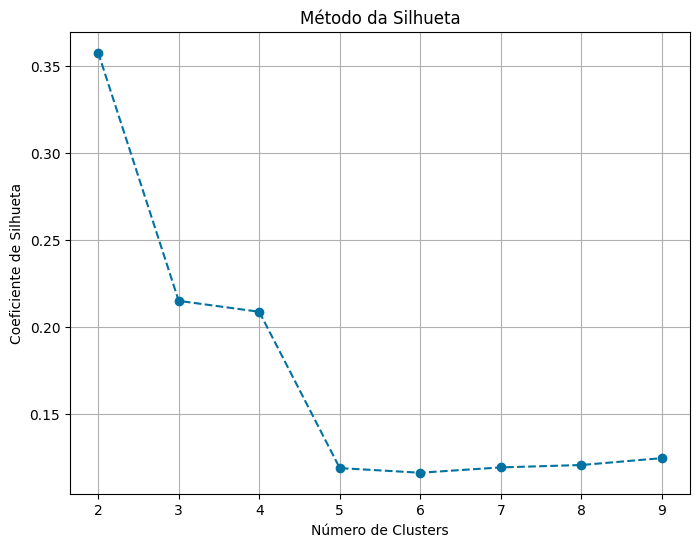

In [ ]:
# Calcular a pontuação da silhueta para diferentes números de clusters
silhouette_scores = []
i = 0
k_min = 2
k_max = 10

for n_clusters in range(k_min, k_max):
    start_time = time.time()
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init='auto')
    cluster_labels = kmeans.fit_predict(df_reduced)
    # gmm = GaussianMixture(n_components=n_clusters, covariance_type='full', random_state=0)
    # gmm.fit(df_reduced)
    # cluster_labels = gmm.predict(df_reduced)

    # spectral_clustering = SpectralClustering(n_clusters=n_clusters, affinity='rbf', gamma=15, random_state=42)
    # cluster_labels = spectral_clustering.fit_predict(df_reduced)
    silhouette_avg = silhouette_score(df_reduced, cluster_labels)
    silhouette_scores.append(silhouette_avg)

    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f'Iteração número: {i} - Coeficiente de Silhueta: {silhouette_avg} - Tempo gasto na iteração: {elapsed_time} segundos')
    i += 1

# Plotar o gráfico do método da silhueta
plt.figure(figsize=(8, 6))
plt.plot(range(k_min, k_max), silhouette_scores, marker='o', linestyle='--', color='b')
plt.xlabel('Número de Clusters')
plt.ylabel('Coeficiente de Silhueta')
plt.title('Método da Silhueta')
plt.xticks(range(k_min, k_max))
plt.grid(True)
plt.show()

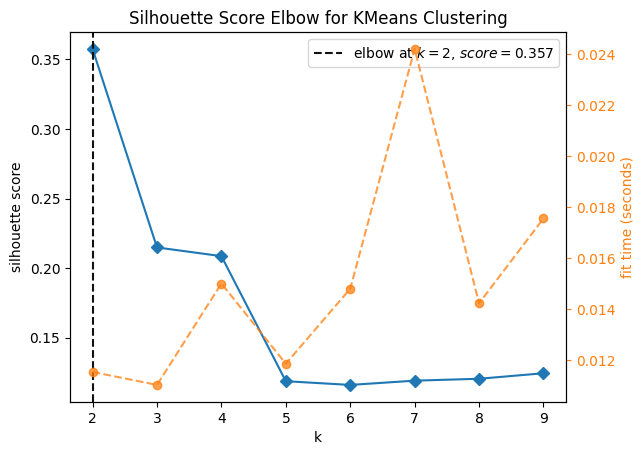

In [ ]:
# Silhouette Score for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans(random_state=0, n_init='auto')
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,10),metric='silhouette', timings= True);
visualizer.fit(df_reduced)        # Fit the data to the visualizer
visualizer.show();        # Finalize and render the figure
plt.style.use('default')

#### 4.1.2.1 K-Means

In [ ]:
# # Treinar o algoritmo K-means com 3 clusters
# kmeans = KMeans(n_clusters=3, random_state=0, n_init='auto')
# kmeans.fit(df_reduced)

# # Obter os centróides dos clusters
# centroids = kmeans.cluster_centers_
# labels = kmeans.labels_

# df_publico['Cluster'] = labels

# np.unique(labels)

#### 4.1.2.2 Modelo de Mistura Gaussiana

In [ ]:
from sklearn.mixture import GaussianMixture

n_components = range(1, 10)
covariance_type = ['spherical', 'tied', 'diag', 'full']
best_bic = float('inf')  # Inicialize com um valor infinito
best_config = None
bic_scores = []

for cov in covariance_type:
    for n_comp in n_components:
        gmm = GaussianMixture(n_components=n_comp, covariance_type=cov, random_state=0)
        gmm.fit(df_reduced)
        bic_score = gmm.bic(df_reduced)
        bic_scores.append((cov, n_comp, bic_score))

        if bic_score < best_bic:
            best_bic = bic_score
            best_config = (cov, n_comp)

print("Melhor configuração:", best_config)
print("Menor BIC:", best_bic)

Melhor configuração: ('full', 7)
Menor BIC: 56397.012079163134


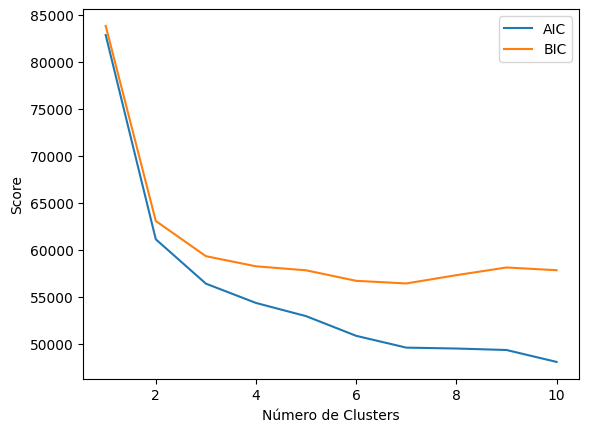

In [ ]:
from sklearn.mixture import GaussianMixture
import numpy as np

# Lista para armazenar valores de AIC e BIC
aic_scores = []
bic_scores = []

# Testar diferentes números de clusters
for n_clusters in range(1, 11):
    gmm = GaussianMixture(n_components=n_clusters, covariance_type='full', random_state=0)
    gmm.fit(df_reduced)
    aic_scores.append(gmm.aic(df_reduced))
    bic_scores.append(gmm.bic(df_reduced))

# Plotar AIC e BIC em função do número de clusters

plt.plot(range(1, 11), aic_scores, label='AIC')
plt.plot(range(1, 11), bic_scores, label='BIC')
plt.xlabel('Número de Clusters')
plt.ylabel('Score')
plt.legend()
plt.show()

##### 4.1.2.2.2 Treino do Modelo

In [ ]:
from sklearn.mixture import GaussianMixture
# Inicializar o modelo de Mistura Gaussiana
gmm = GaussianMixture(n_components=7, covariance_type='full', random_state=0)

# Ajustar o modelo aos dados com parâmetros de inicialização específicos
gmm.fit(df_reduced)

# Prever os rótulos dos clusters
labels = gmm.predict(df_reduced)

df_publico['Cluster'] = labels

np.unique(labels)

array([0, 1, 2, 3, 4, 5, 6])

### 4.1.3 Análise dos Clusters Gerados

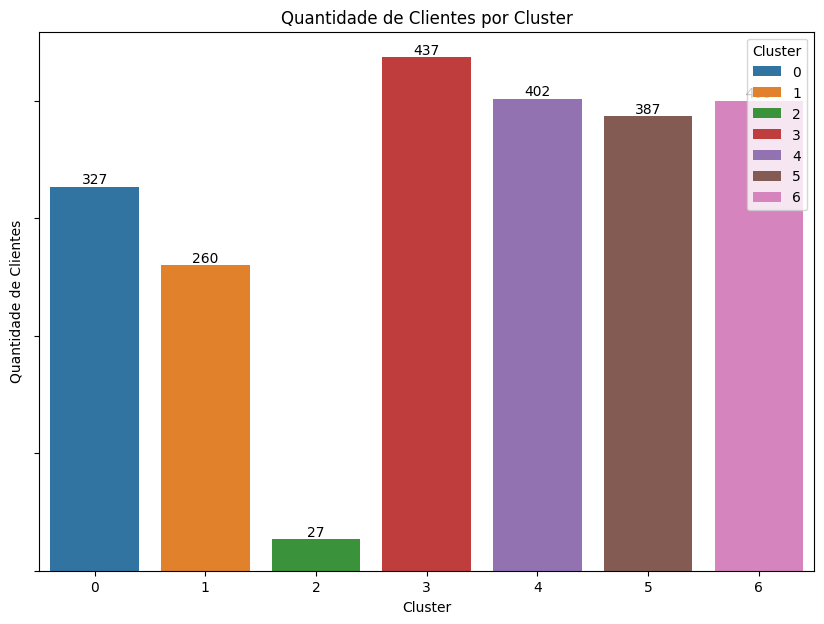

In [ ]:
pal = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
pal = pal[:len(np.unique(labels))]

plt.figure(figsize=(10,7))
pl = sns.countplot(data=df_publico, x="Cluster",hue="Cluster",palette=pal)

for i in range(len(pl.containers)):
  pl.bar_label(pl.containers[i], fontsize=10)
pl.set_title("Quantidade de Clientes por Cluster")
plt.gca().axes.yaxis.set_ticklabels([])
plt.ylabel('Quantidade de Clientes')
plt.show()

Nota-se que:

* 19,51% dos clientes estão concentrados no cluster 3;
* O segundo cluster com maior participação é o cluster 4, representando 17,95% do total;
* O cluster 2 apresentou a menor participação, correspondendo a aproximadamente 1,21% do total.


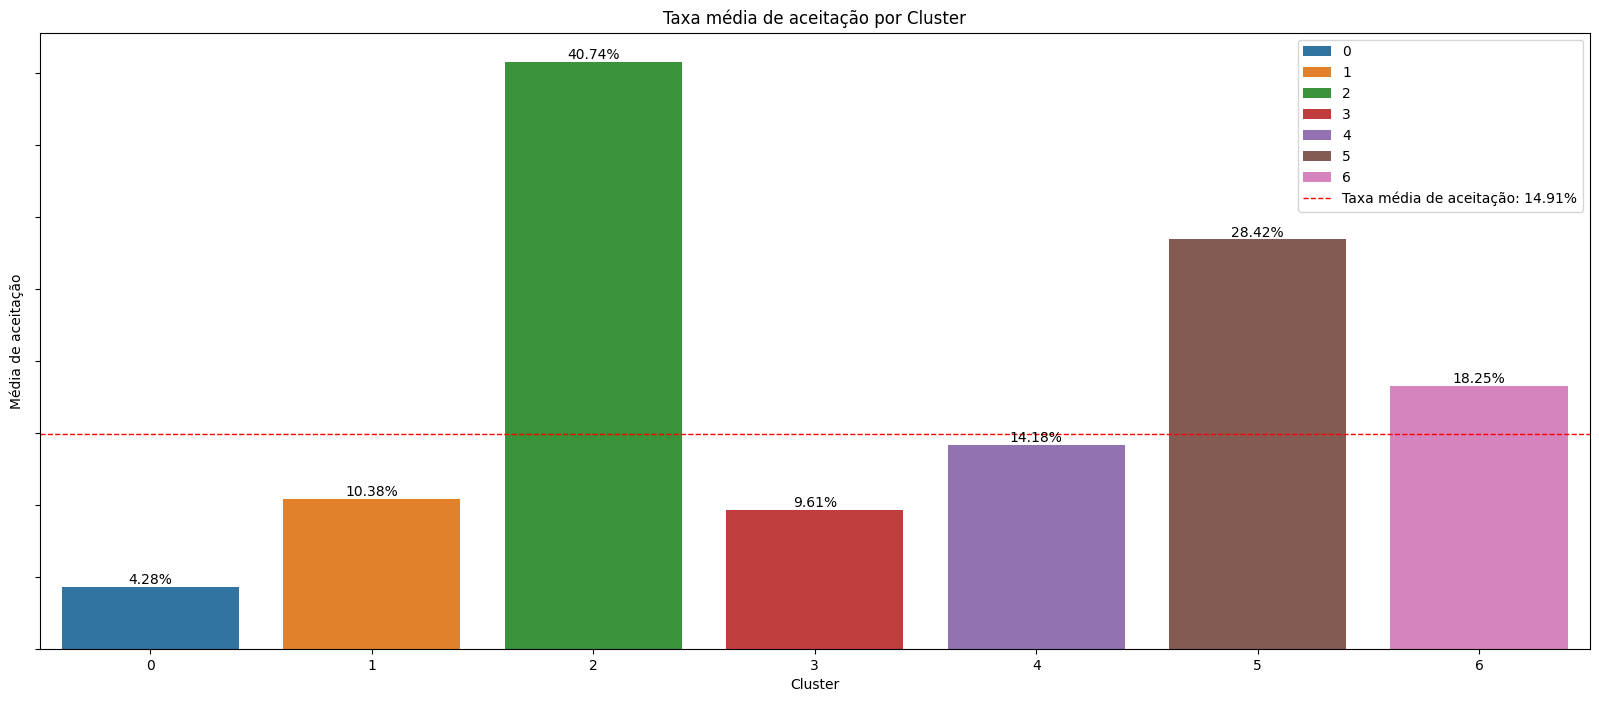

In [ ]:
df_publico['TARGET'] = (df_publico['AceitouUltimaCampanha'] == 1).astype(int)

# Calcular a média da variável "AceitouUltimaCampanha" para cada cluster
mean_aceitacao_by_cluster = df_publico.groupby("Cluster")["TARGET"].mean().reset_index()

# Plotar o gráfico de barras
plt.figure(figsize=(20, 8))
sns.barplot(x="Cluster", y="TARGET", data=mean_aceitacao_by_cluster, palette=pal, hue="Cluster")
plt.axhline(taxa_media_aceitacao, color='red', linestyle='dashed', linewidth=1, label='Taxa média de aceitação: {:.2f}%'.format(taxa_media_aceitacao * 100))

plt.title("Taxa média de aceitação por Cluster")
plt.xlabel("Cluster")
plt.ylabel("Média de aceitação")



# Adicionando os valores das taxas de aceitacao nas barras
for i, taxa in enumerate(mean_aceitacao_by_cluster.TARGET.values):
    plt.text(i, taxa, '{:.2f}%'.format(taxa * 100), ha='center', va='bottom', fontsize=10)

plt.gca().axes.yaxis.set_ticklabels([])
plt.legend()
plt.show()

Verifica-se que:

* Os clusters 5 e 6 apresentam as maiores taxas de aceitação, com 28.42% e 18.25%, respectivamente;
* Os demais clusters estão abaixo da média de aceitação.
* Por mais que o Cluster 2 esteja acima da média, não estamos o considerando devido seu baixo volume


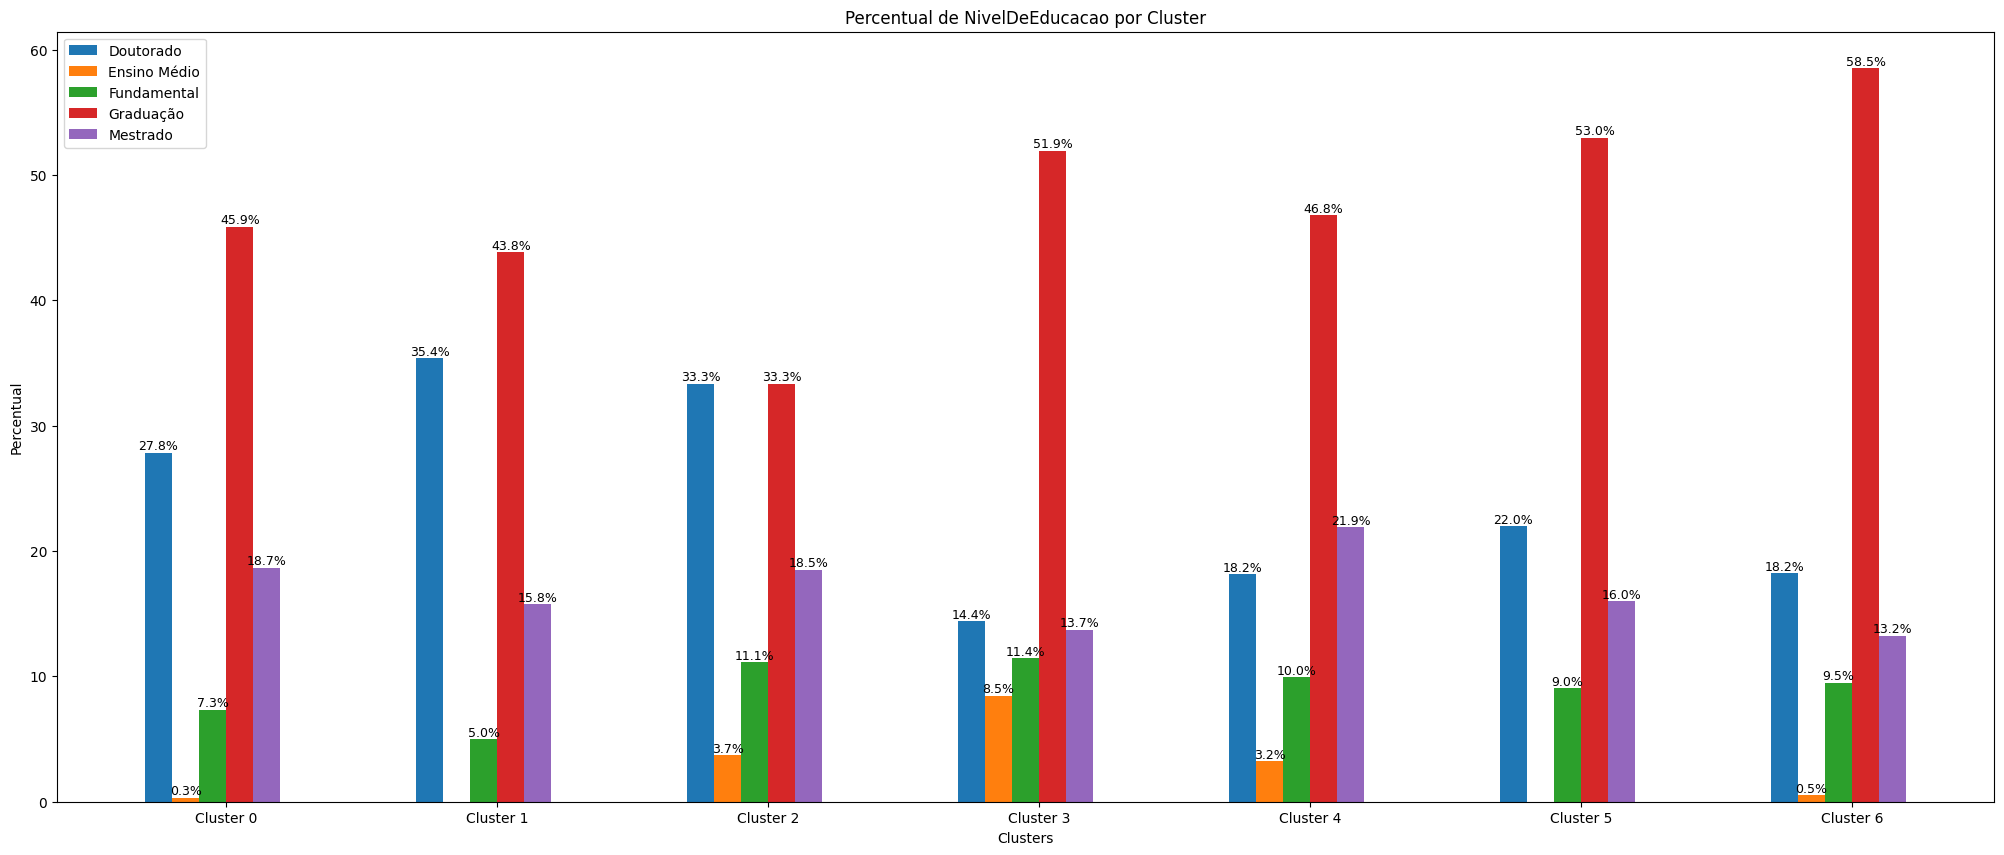

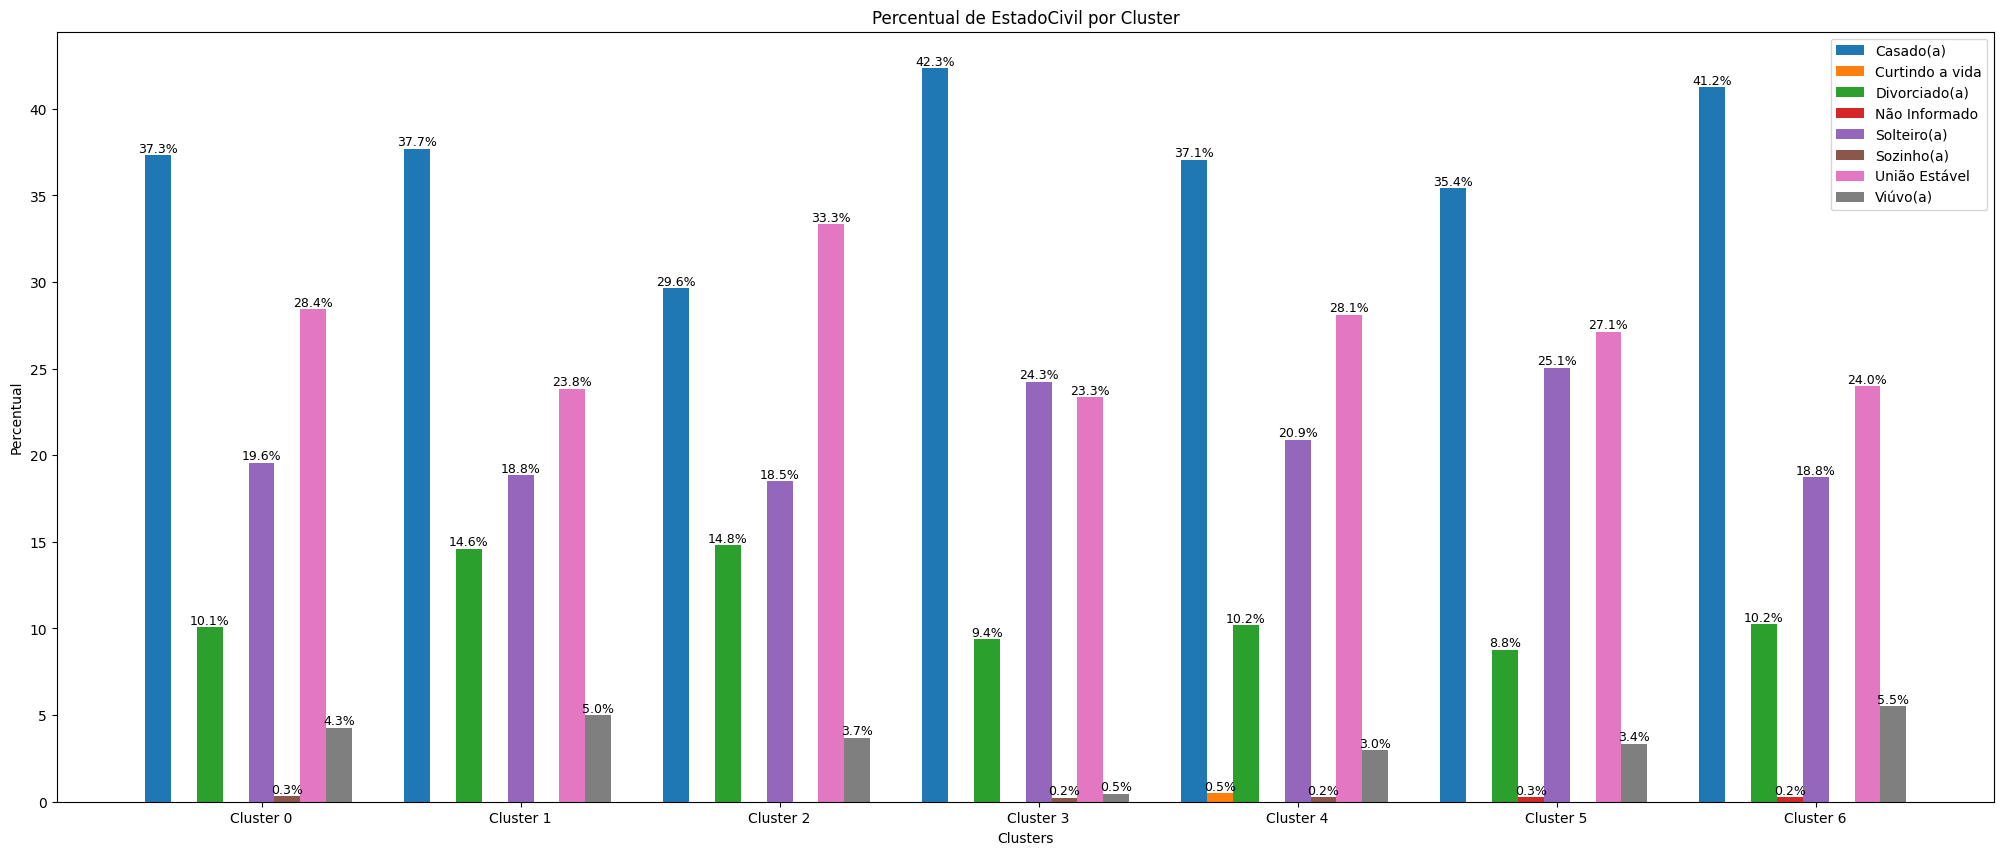

In [ ]:
# Variáveis a serem analisadas:
vars1 = list(cat_attributes.columns).copy()

vars_categoricas = vars1

for var in vars_categoricas:
  percentuais_por_cluster = df_publico.groupby('Cluster')[var].value_counts(normalize=True).mul(100).unstack().reset_index().values

  # Extrair os clusters e os percentuais de satisfação
  clusters = percentuais_por_cluster[:, 0]
  percentuais = percentuais_por_cluster[:, 1:]

  # Largura da barra
  bar_width = 0.1

  # Coordenadas das barras
  x = np.arange(len(clusters))

  # Plotar o gráfico de barras
  plt.figure(figsize=(25, 10))

  unicos = sorted(df_publico[var].unique())
  for i in range(len(percentuais[0])):
      j = unicos[i]
      plt.bar(x + i * bar_width, percentuais[:, i], bar_width, label=f'{j}')
      for j, val in enumerate(percentuais[:, i]):
          plt.text(x[j] + i * bar_width, val, '{:.1f}%'.format(val), ha='center', va='bottom', fontsize=9);

  # Adicionar rótulos e título
  plt.xlabel('Clusters');
  plt.ylabel('Percentual');
  plt.title(f'Percentual de {var} por Cluster');
  plt.xticks(x + bar_width * len(percentuais[0]) / 2, [f'Cluster {int(cluster)}' for cluster in clusters]);
  plt.legend(loc='best');

  # Mostrar o gráfico
  plt.show();

Insights gerados:

* Nível de Educação:
  * Nos clusters 5 não temos presença de clientes com Ensino Médio, enquanto no Cluster 6 apenas 0,5% dos clientes presentes possuem Ensino Médio;
  * O cluster 6 apresentar o maior percentual de pessoam com Graduação (58.5%), seguido pelo cluster 5 que apresenta (53,9%) do público com Graduação.

* Estado Civil:
  * O cluster 5 possui a maior concentração percentual de clientes solteiros (25.1%);
  * O cluster 6 apresenta o segundo maior percentual de clientes casados (41.7%), além de apresentar o maior número de clientes viúvos (5.5%)

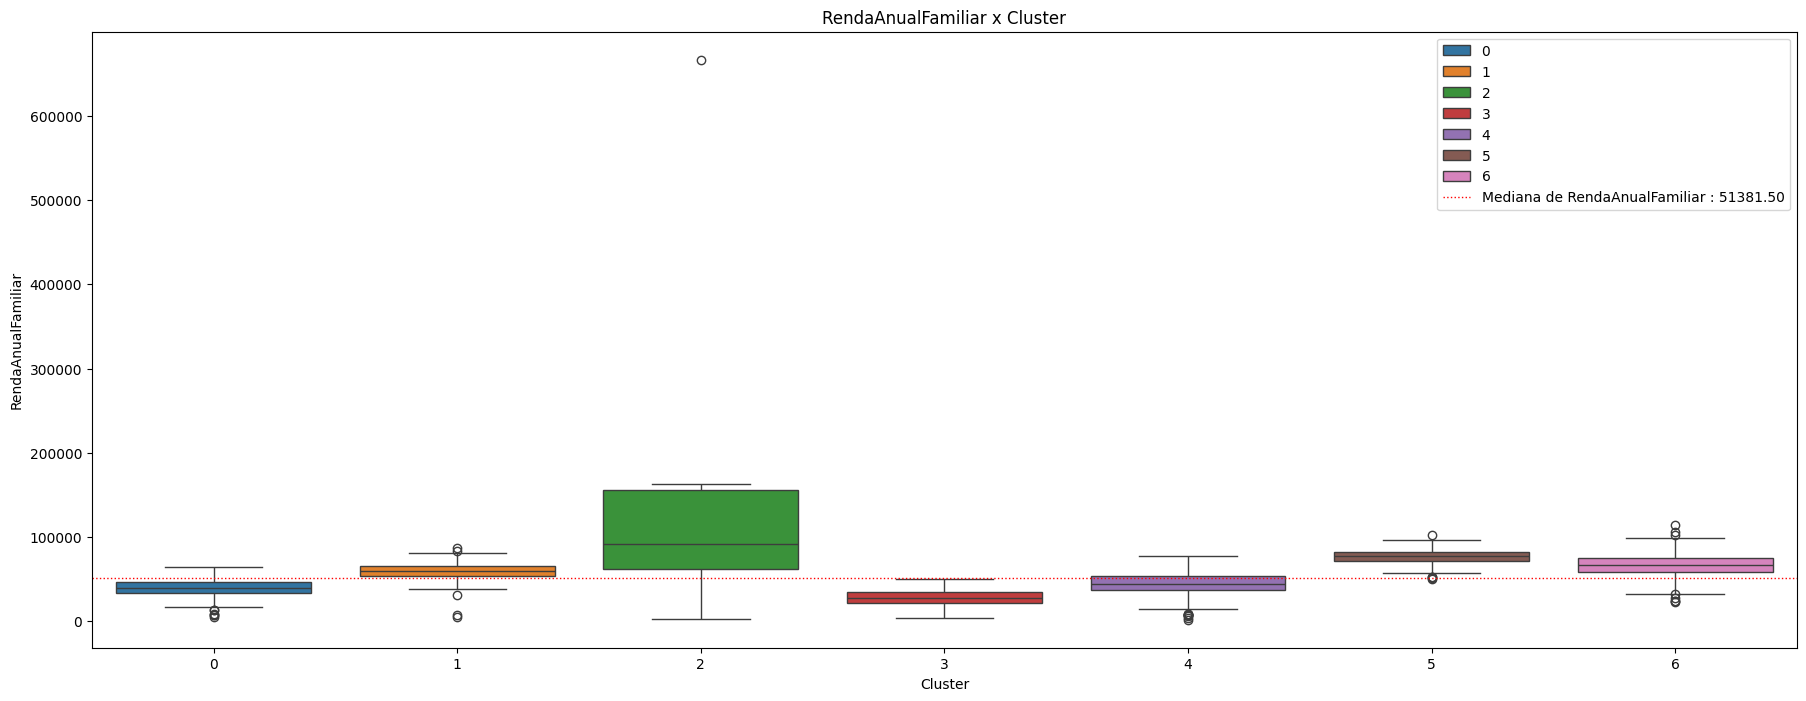

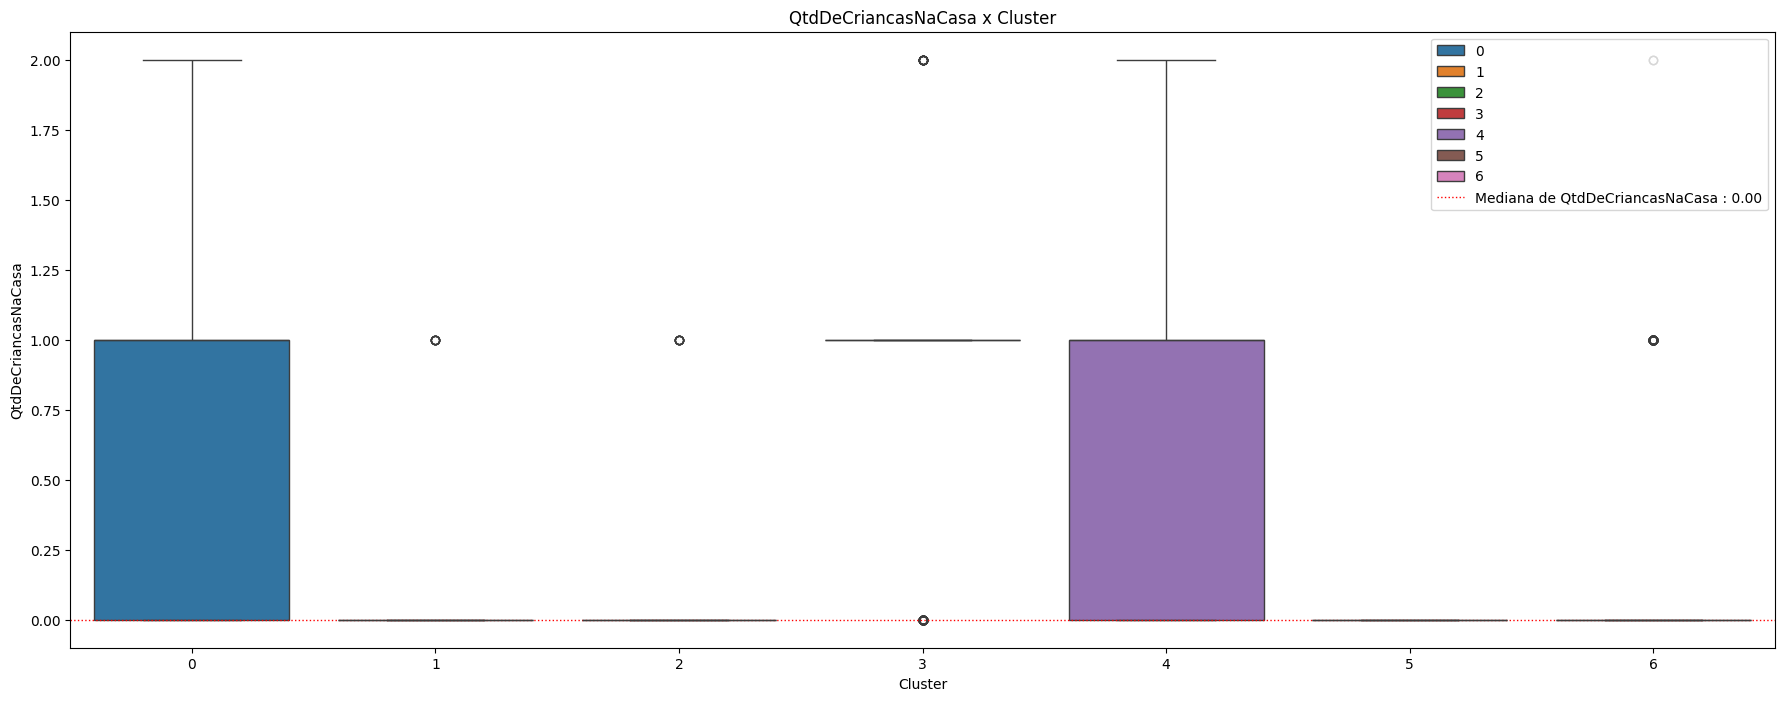

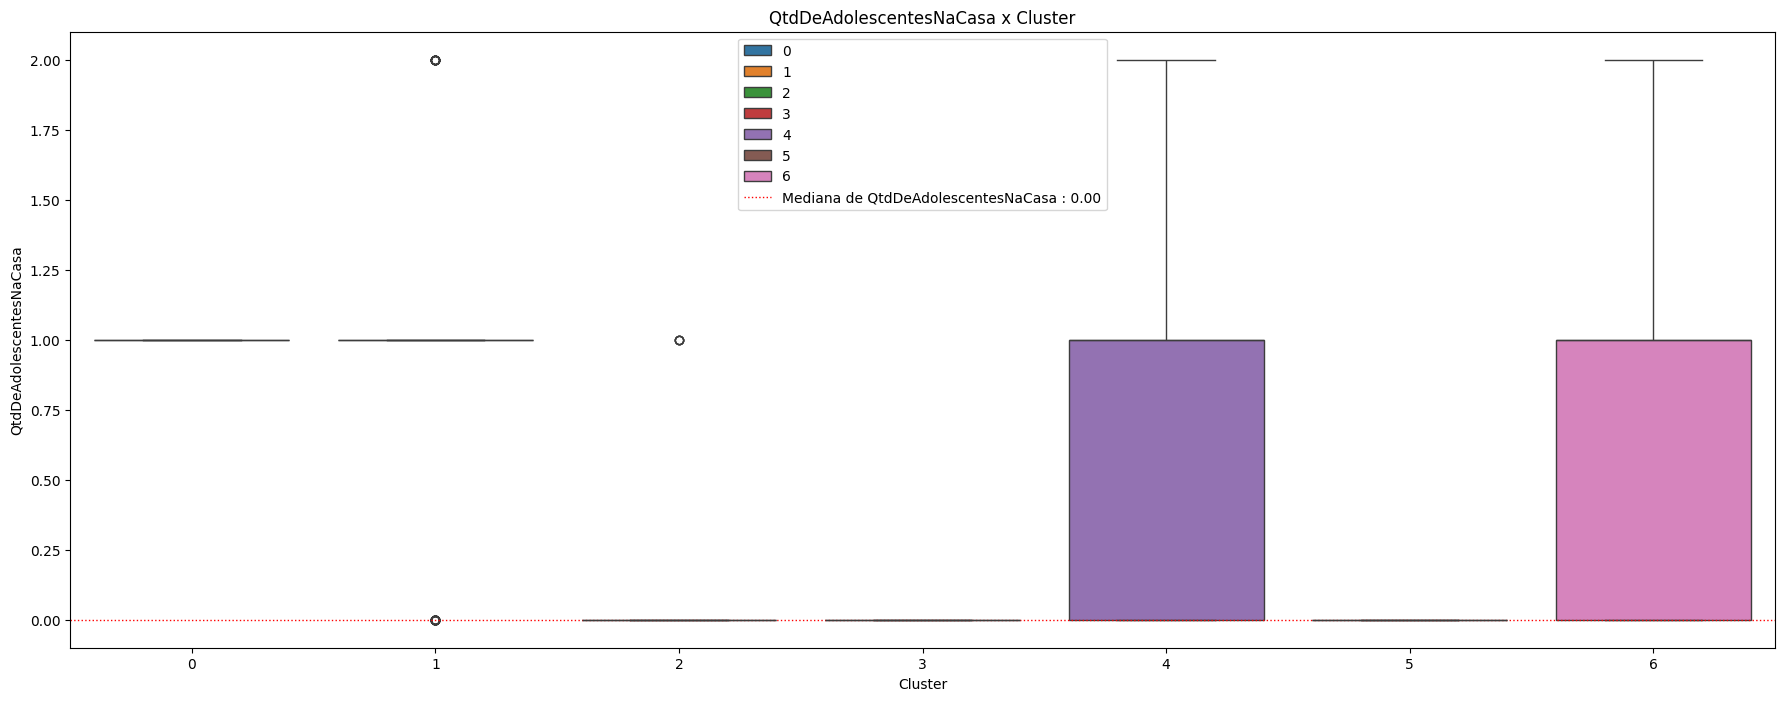

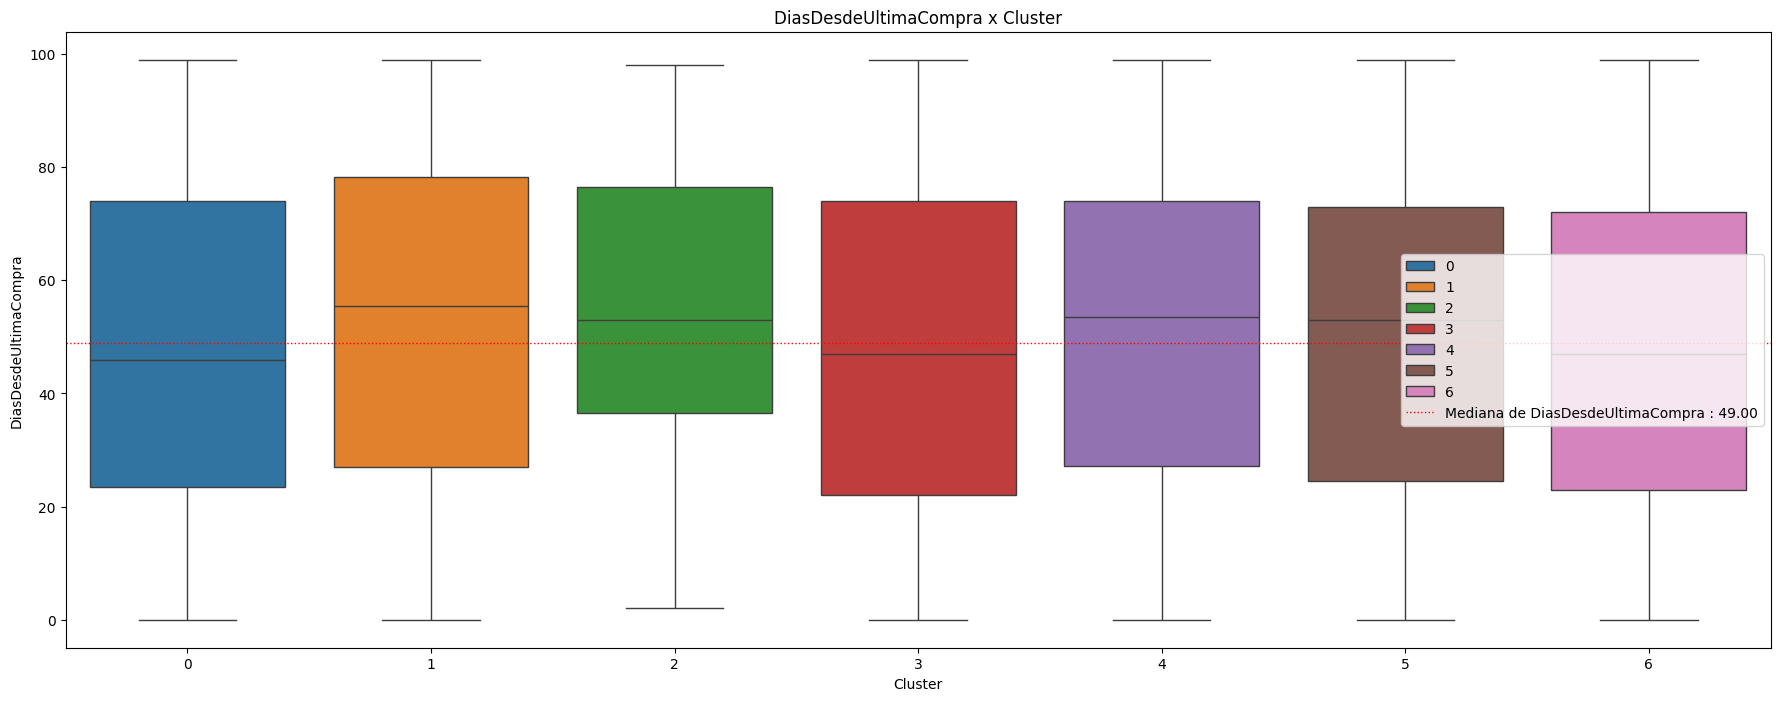

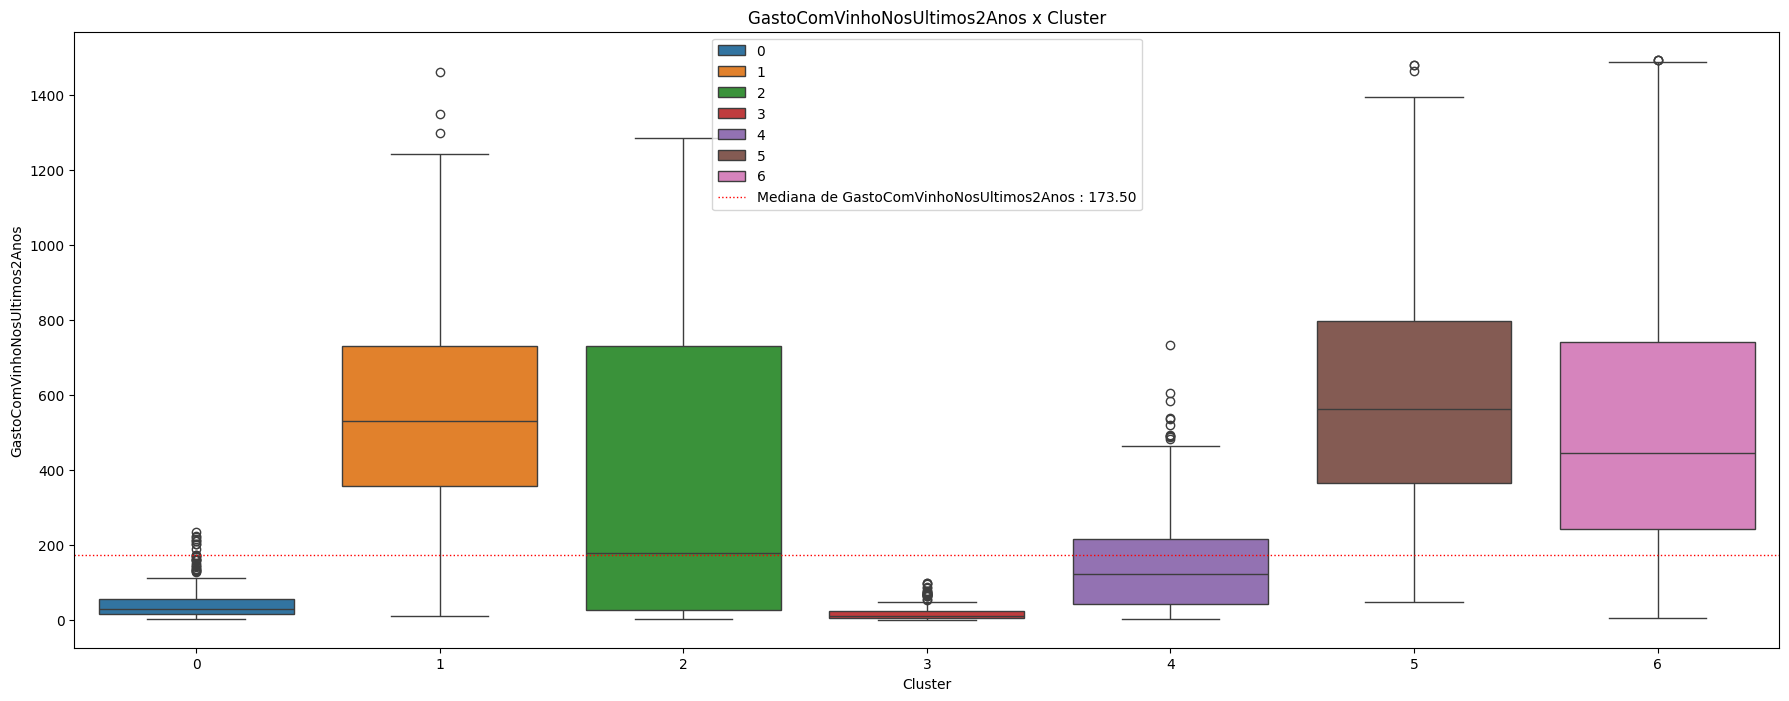

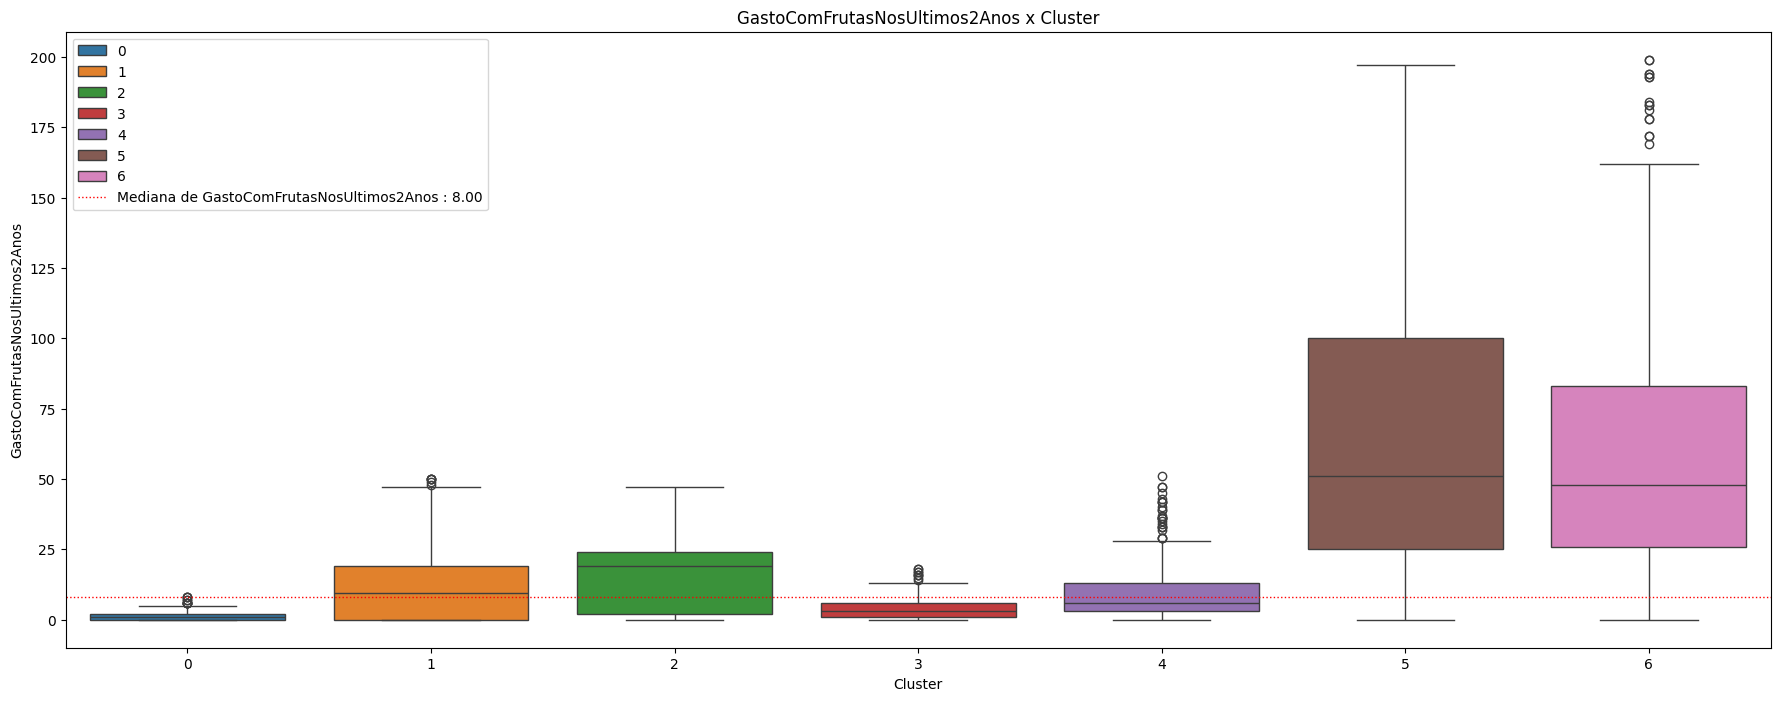

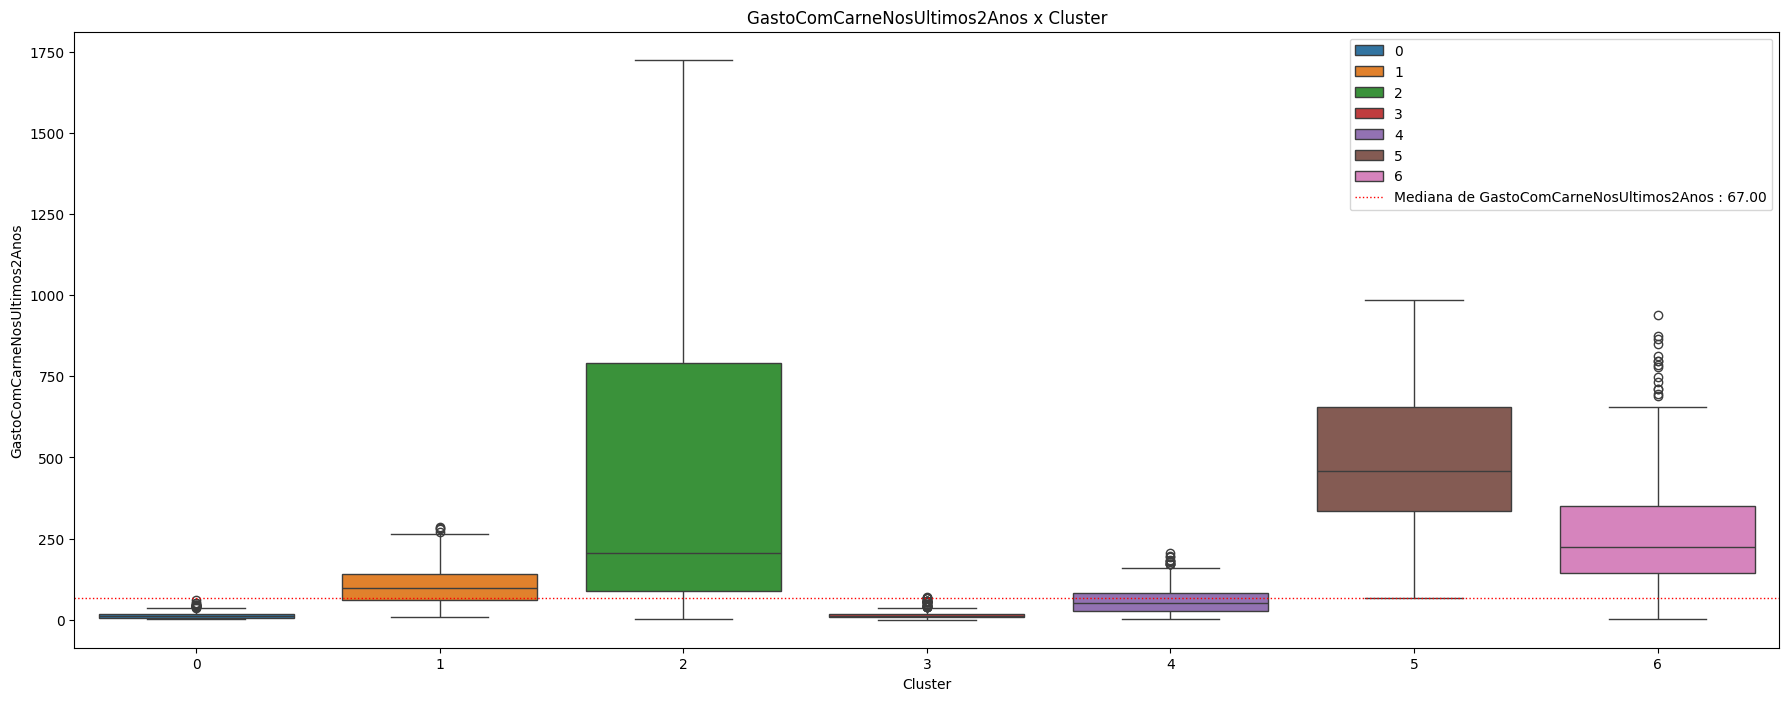

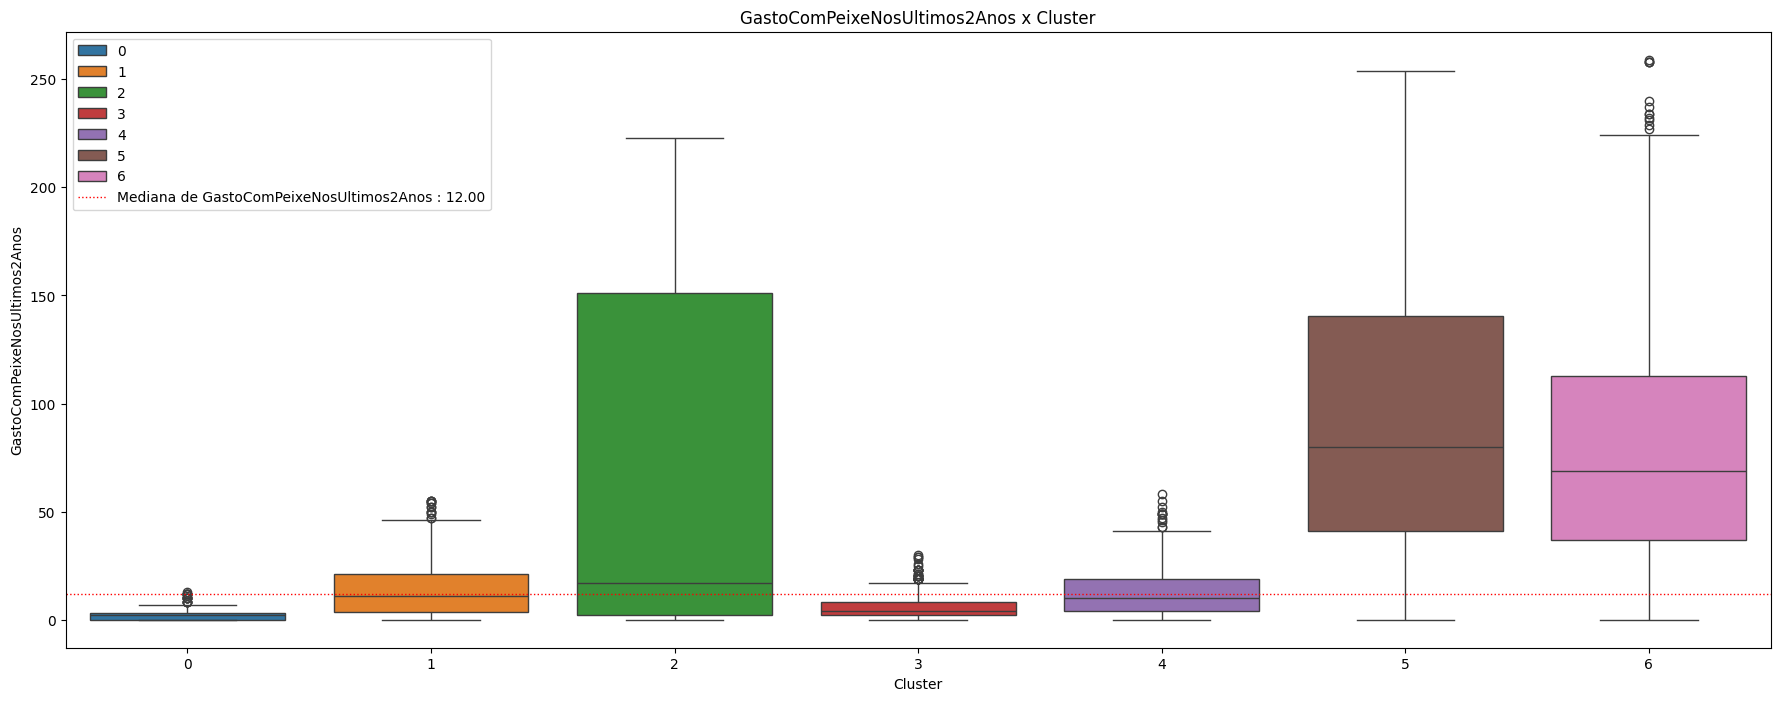

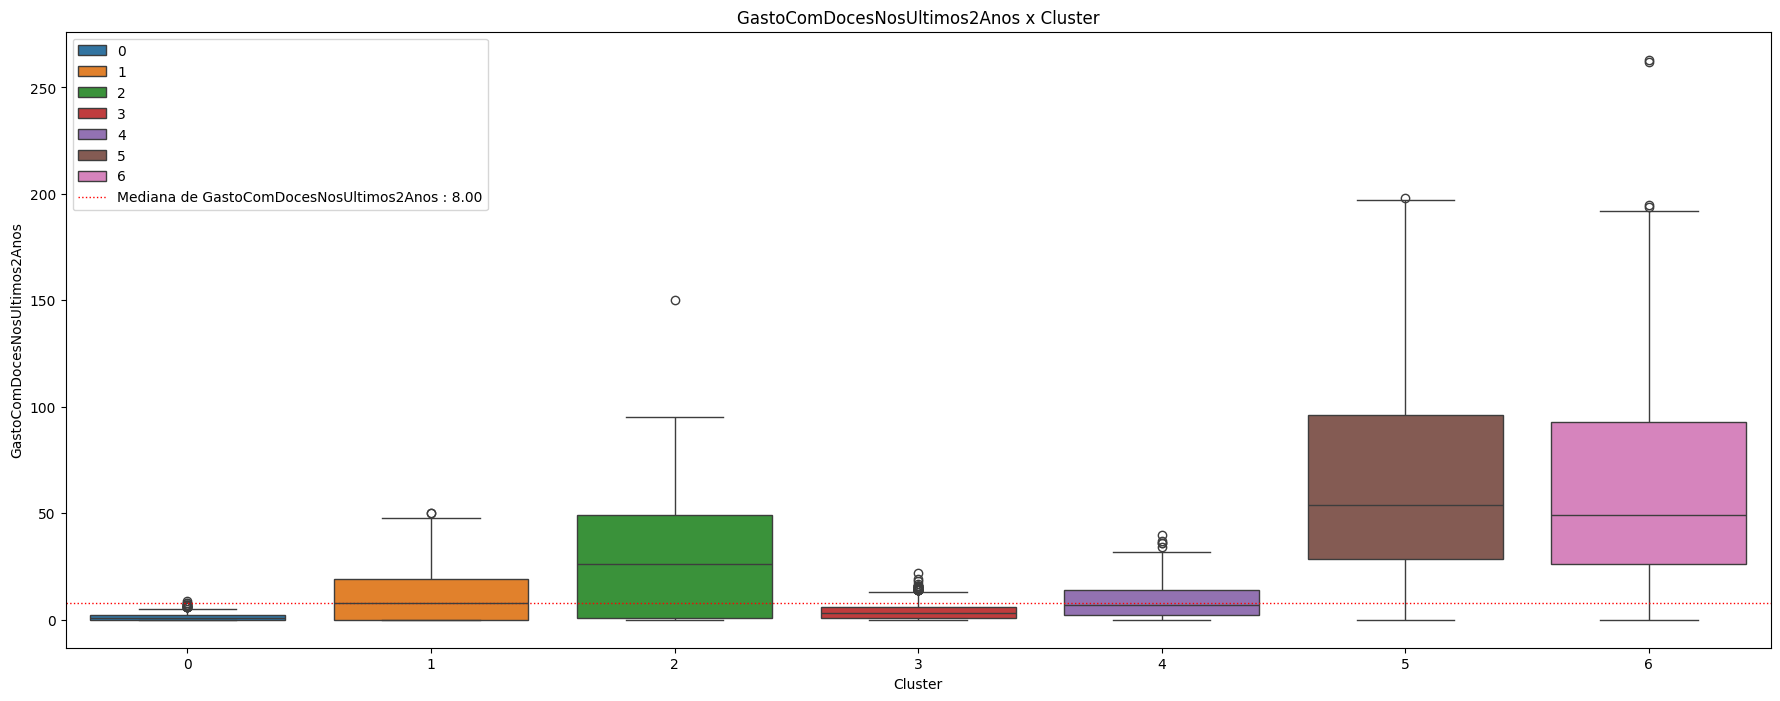

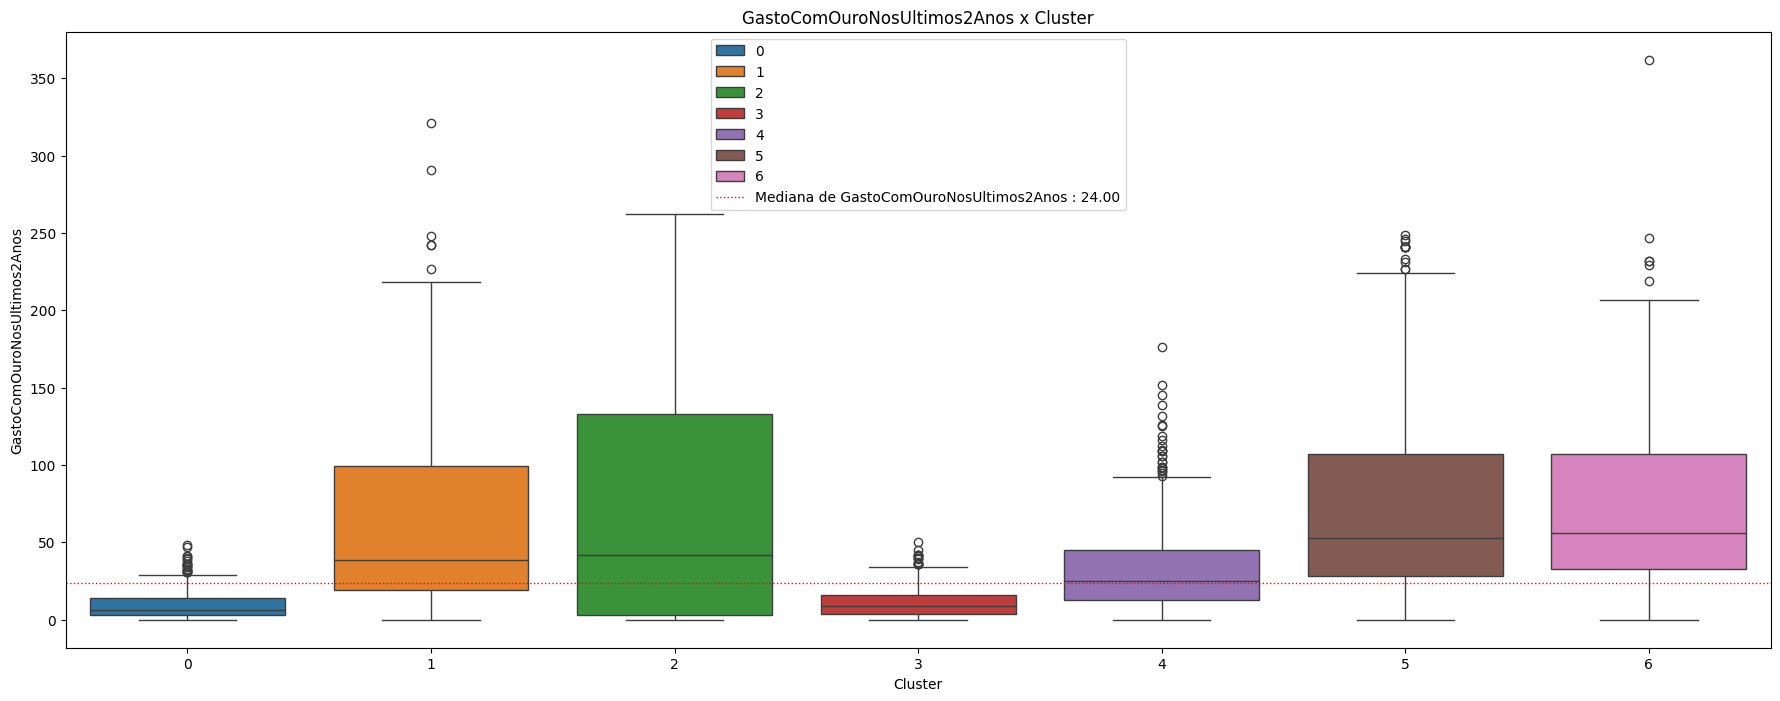

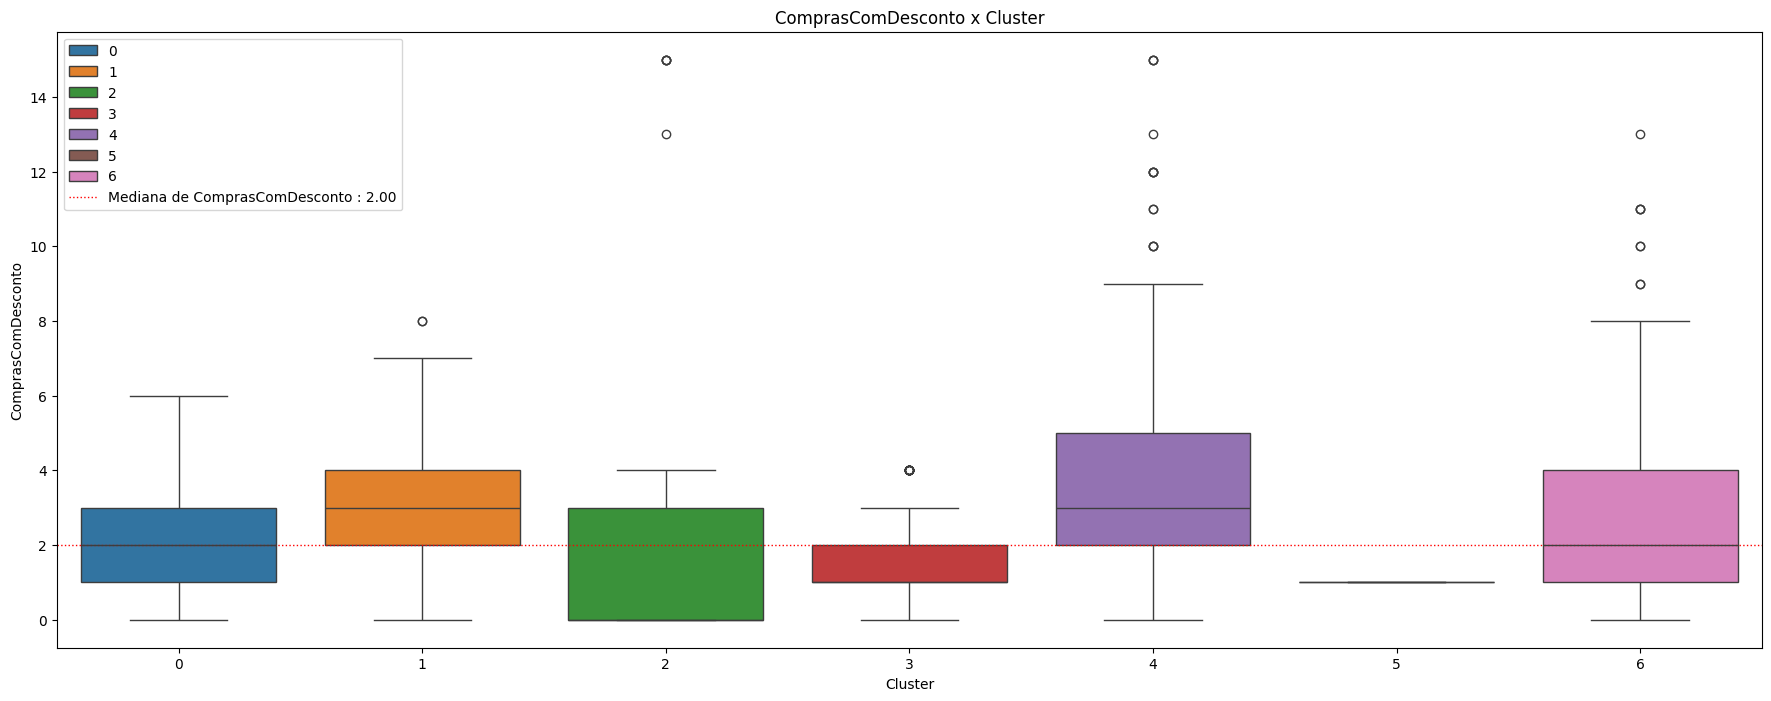

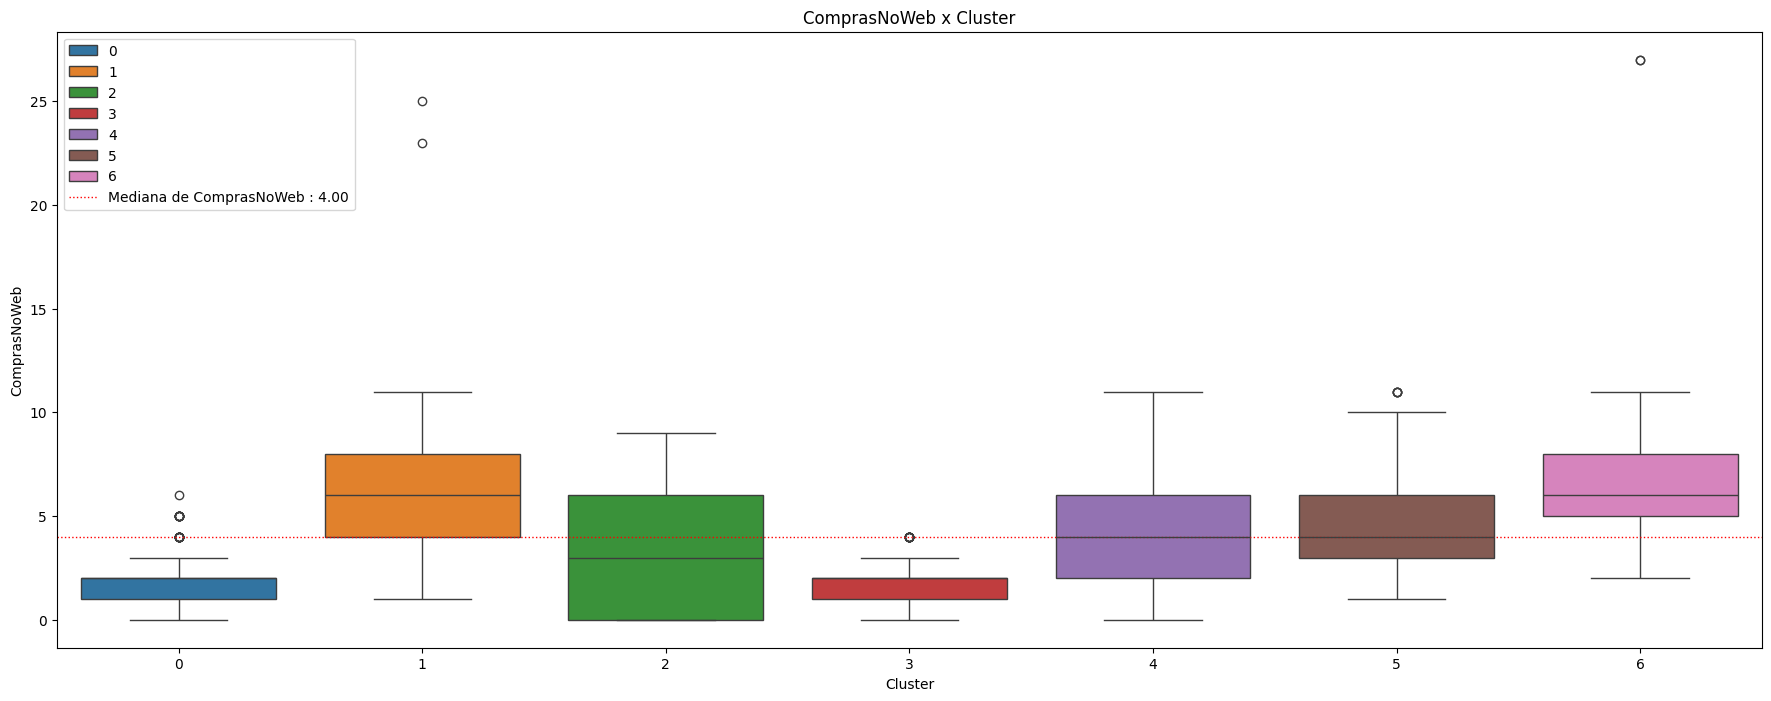

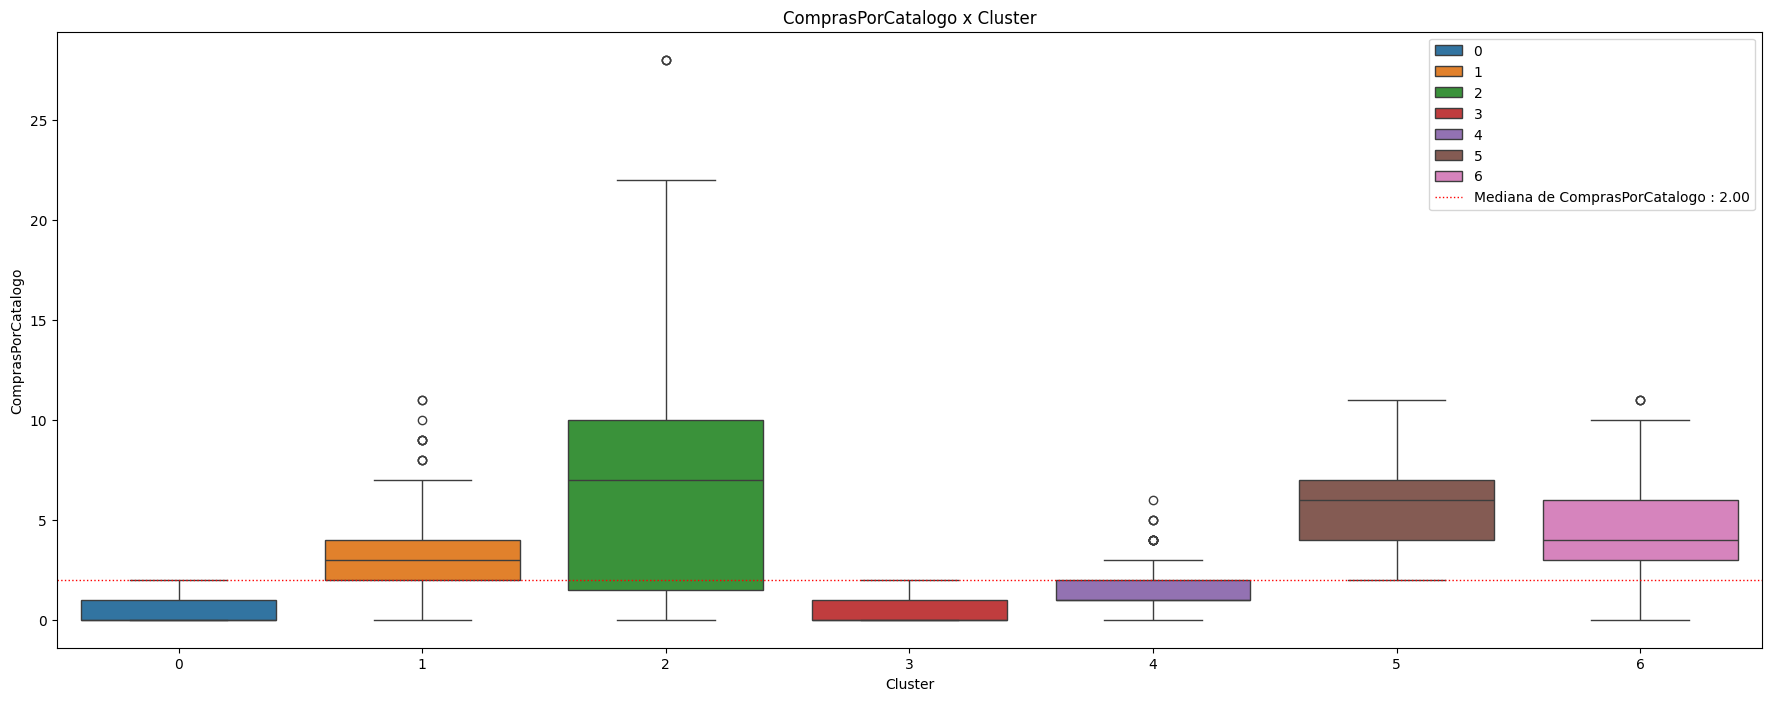

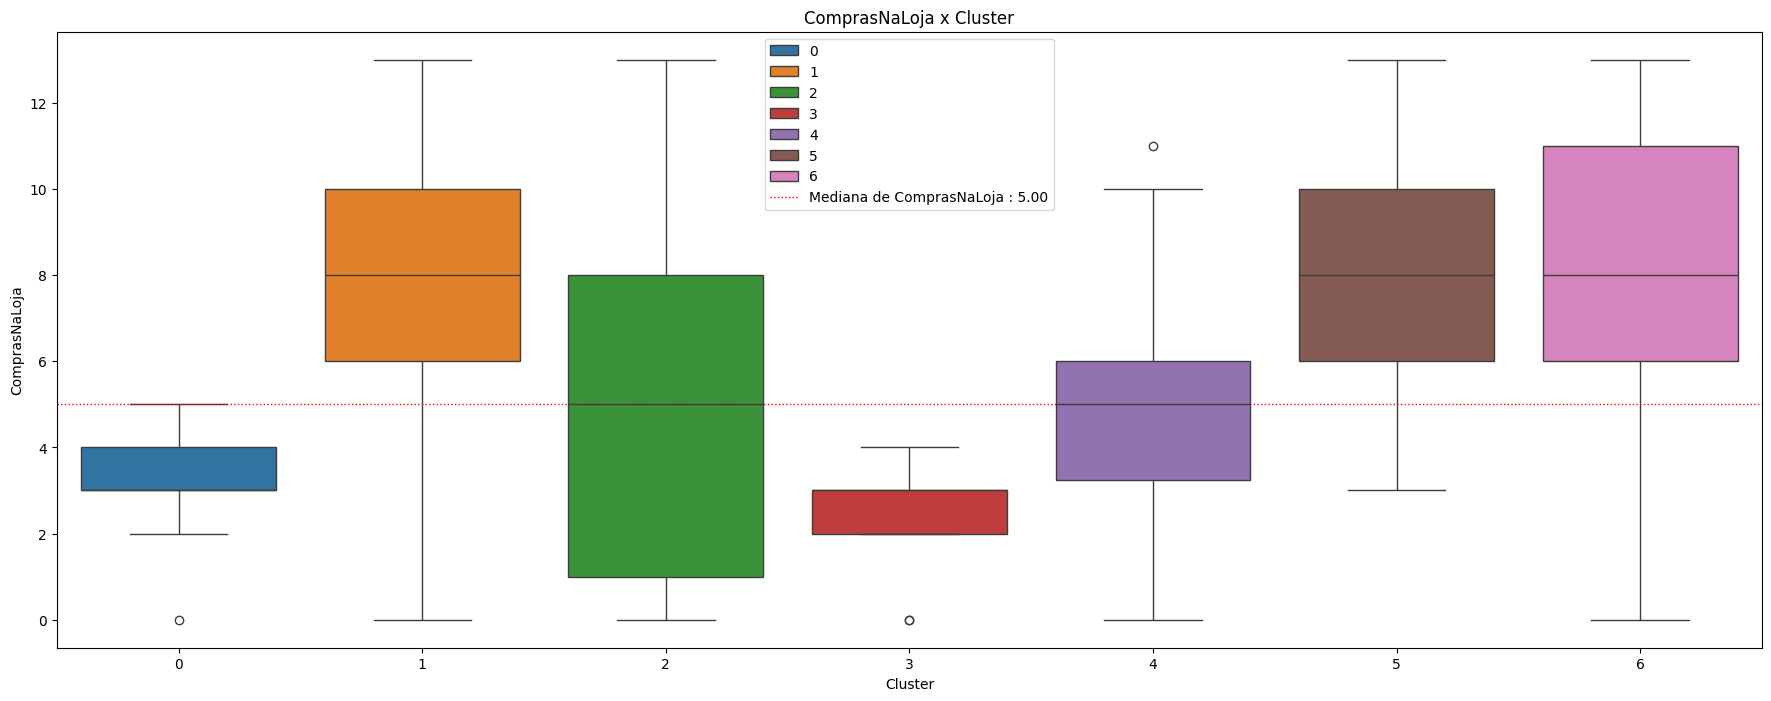

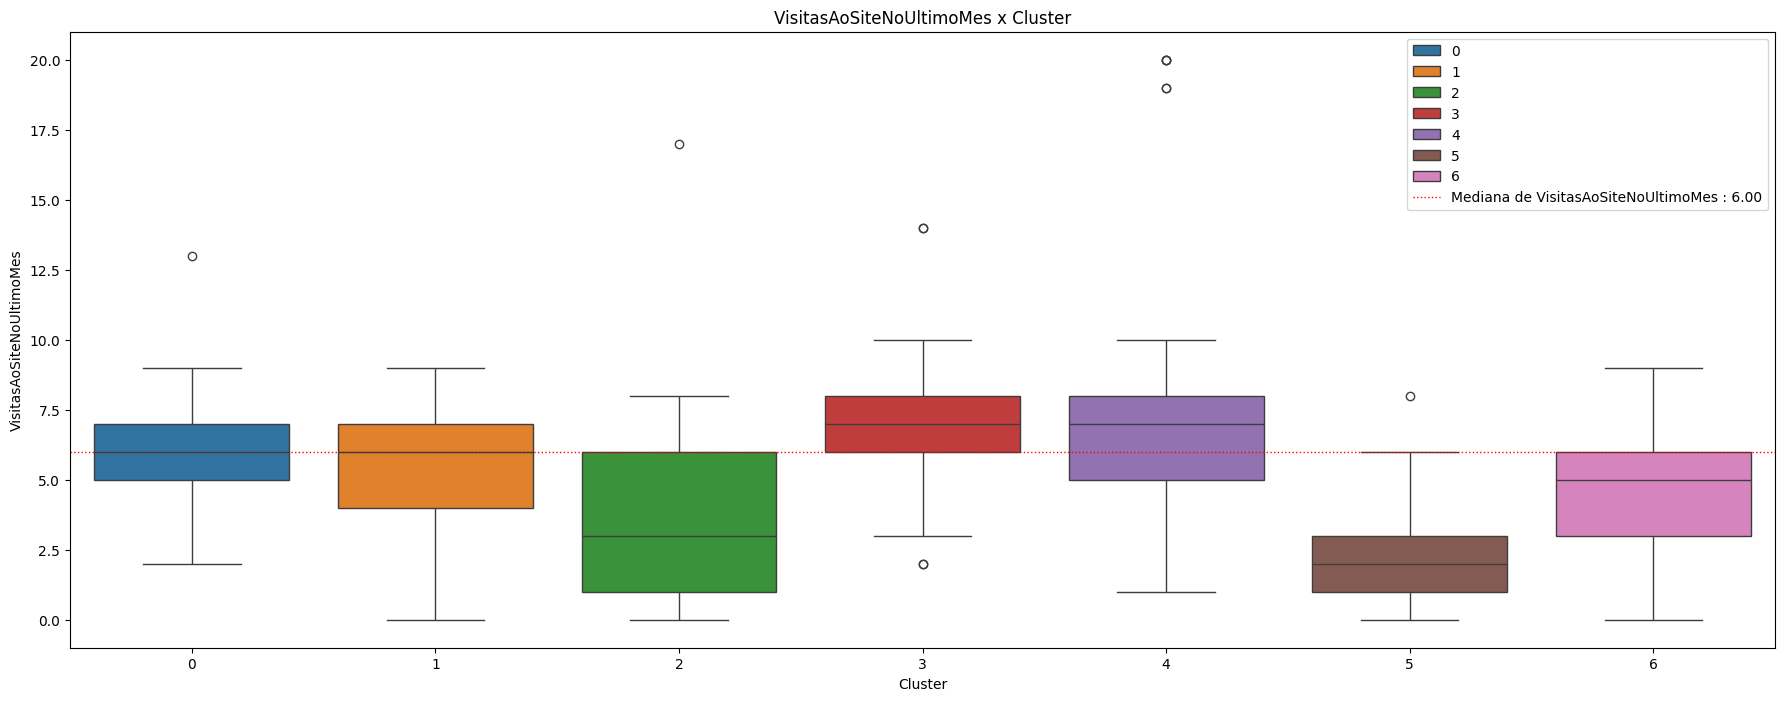

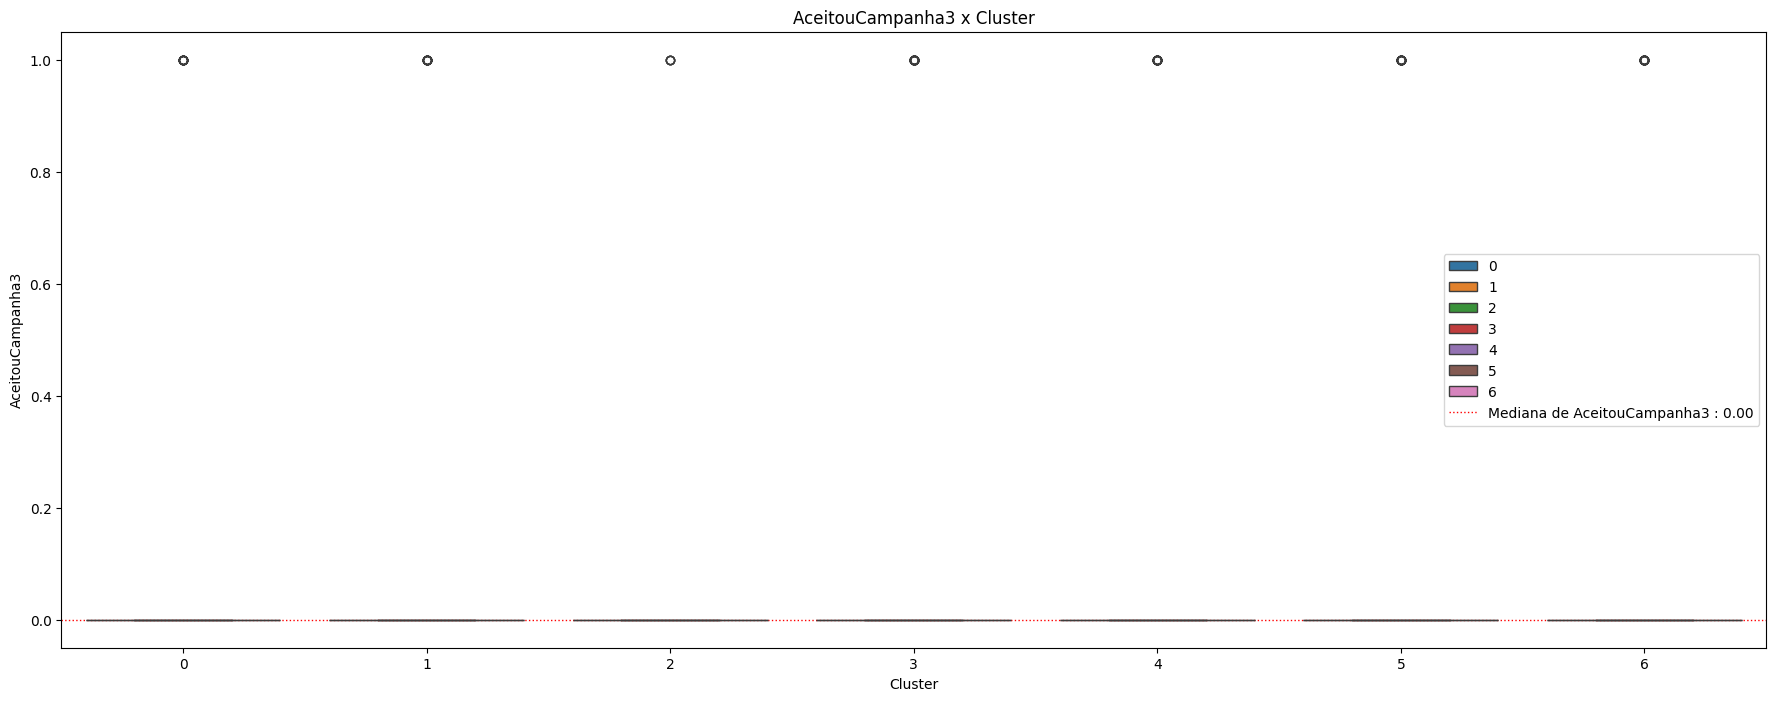

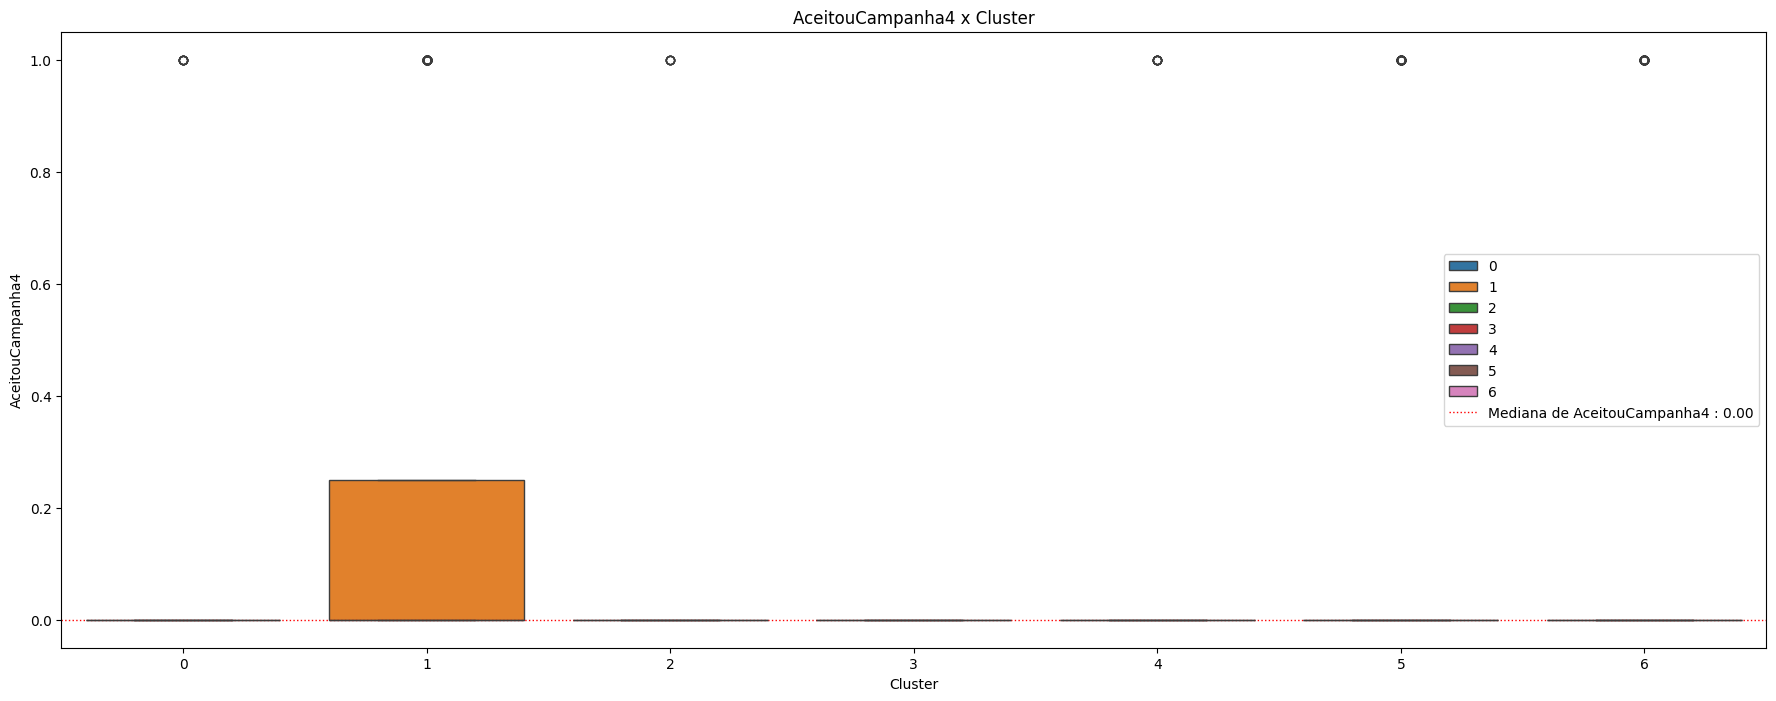

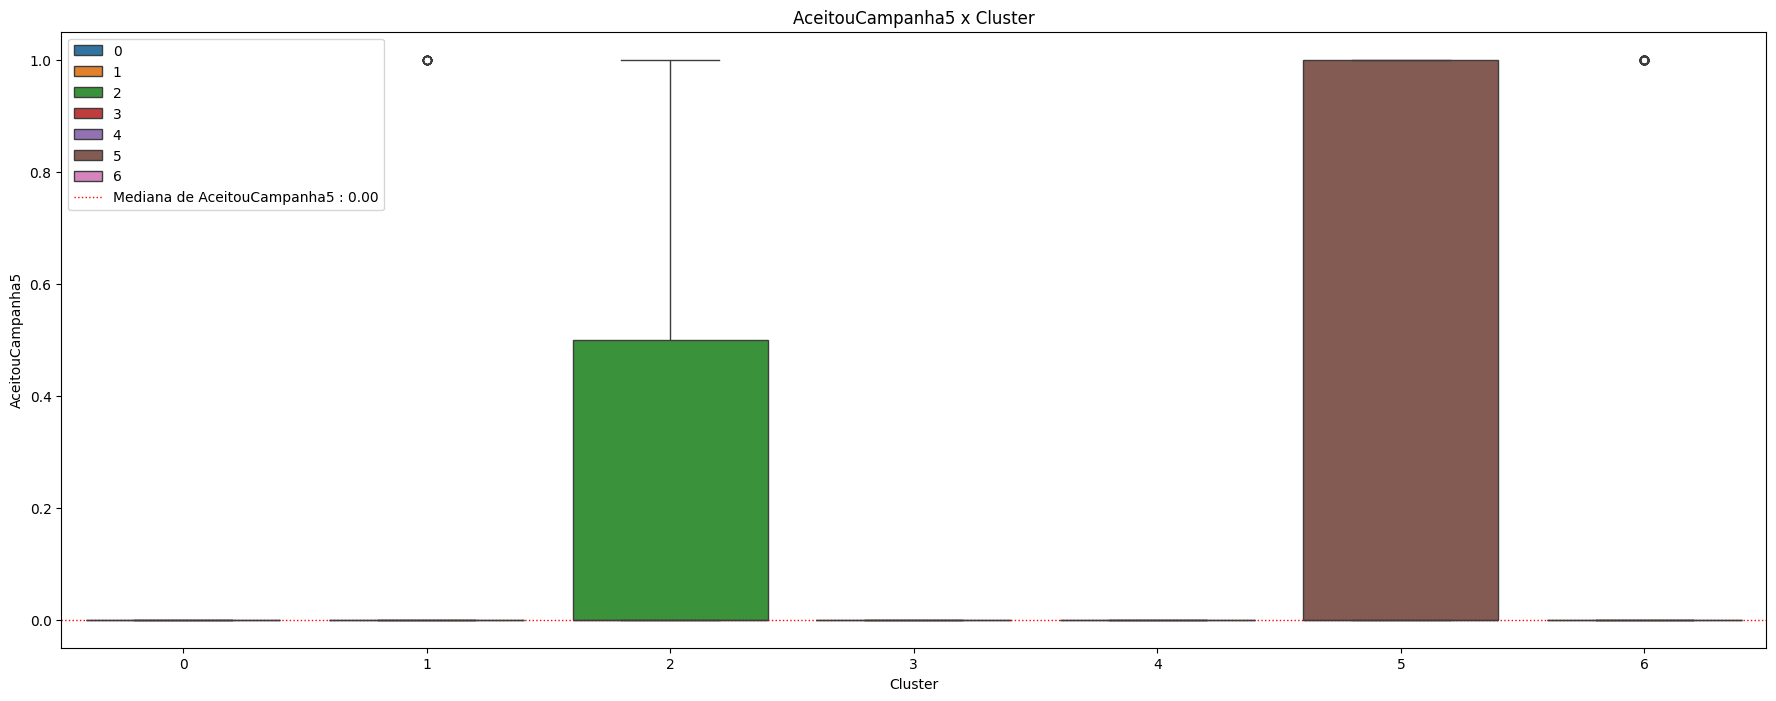

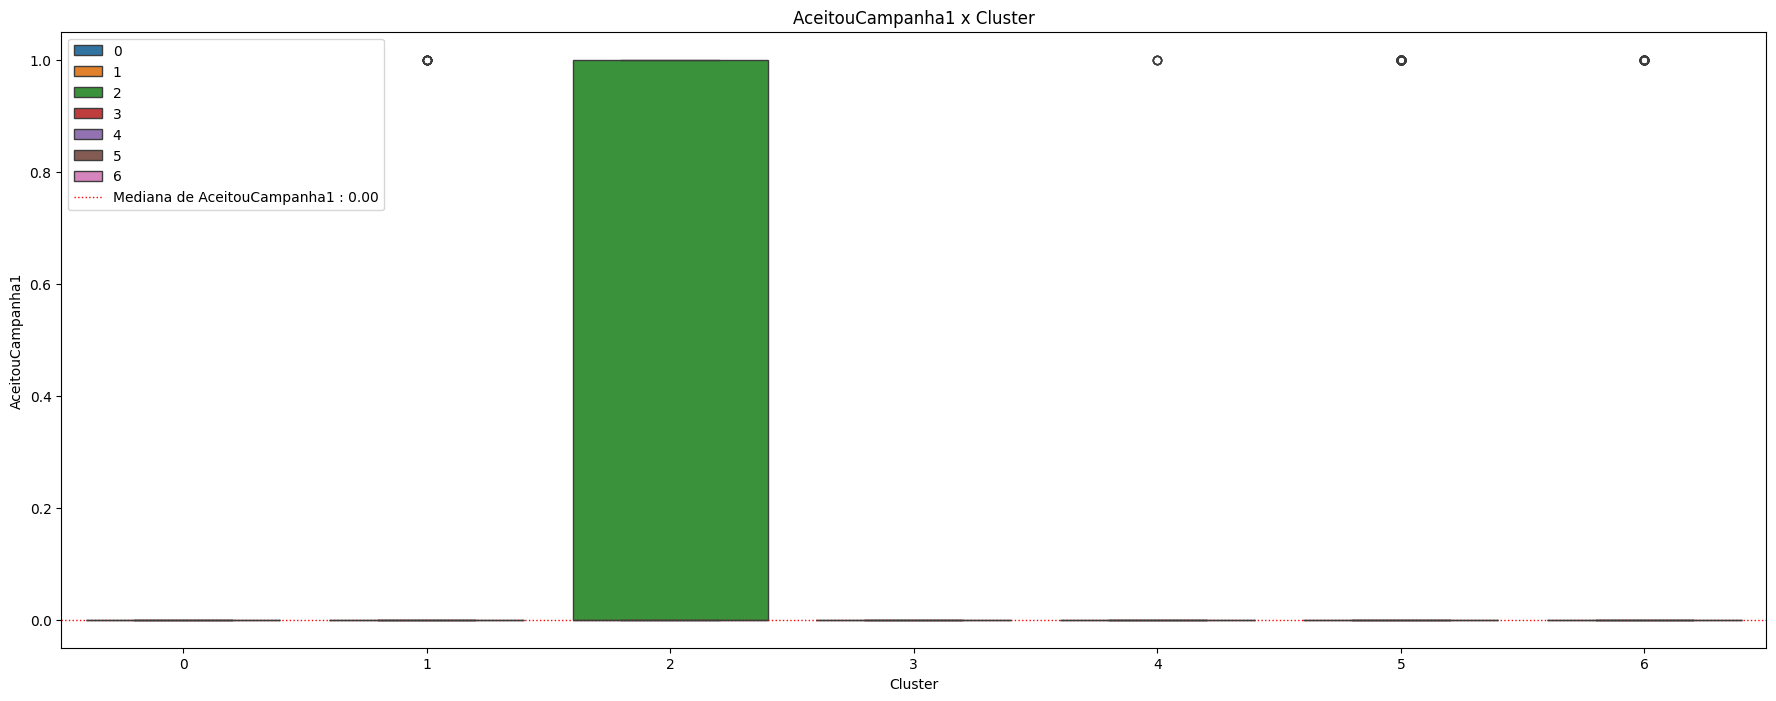

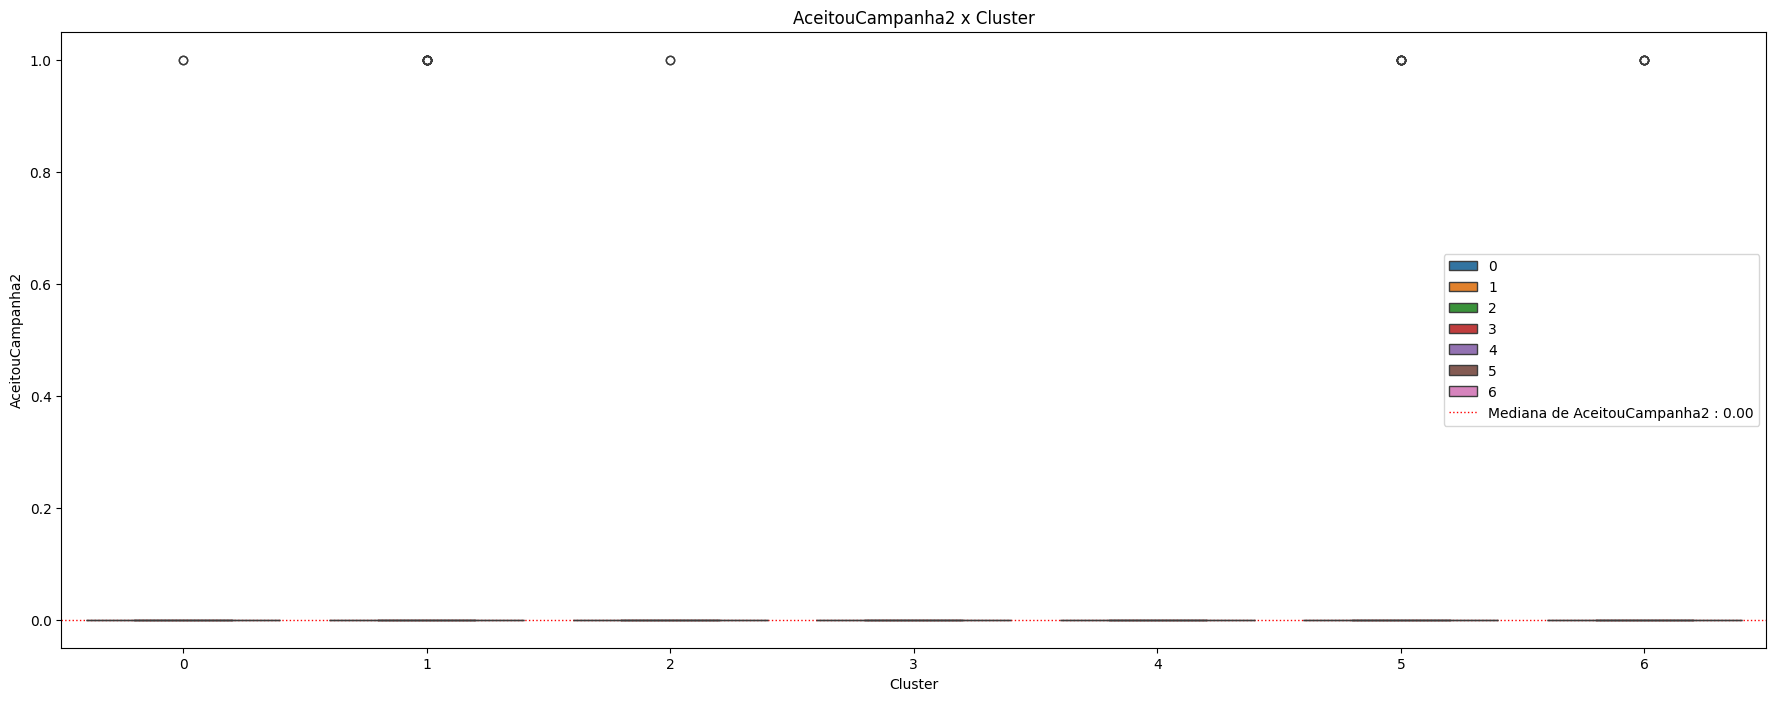

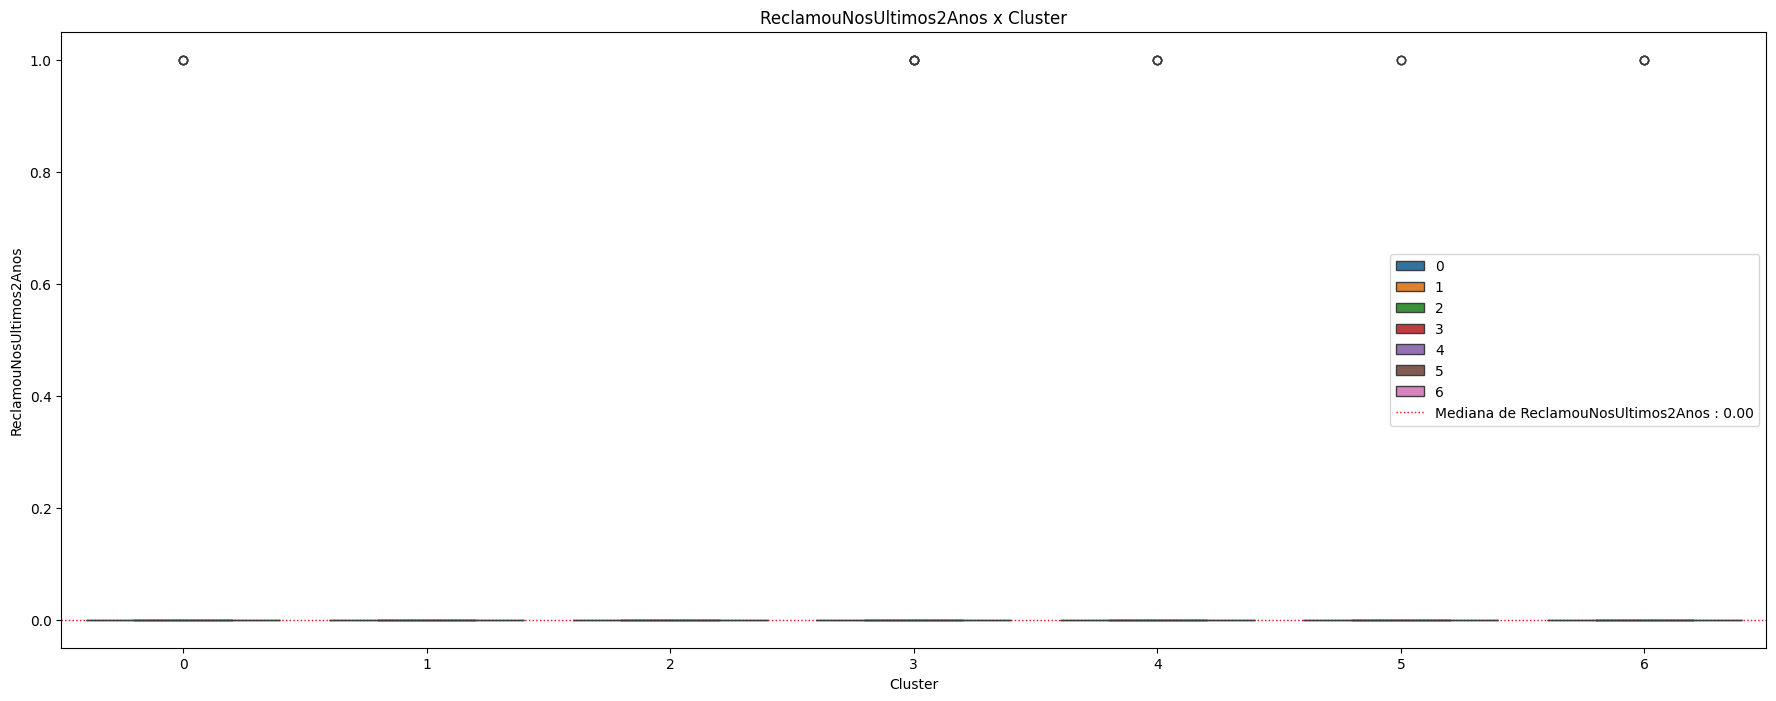

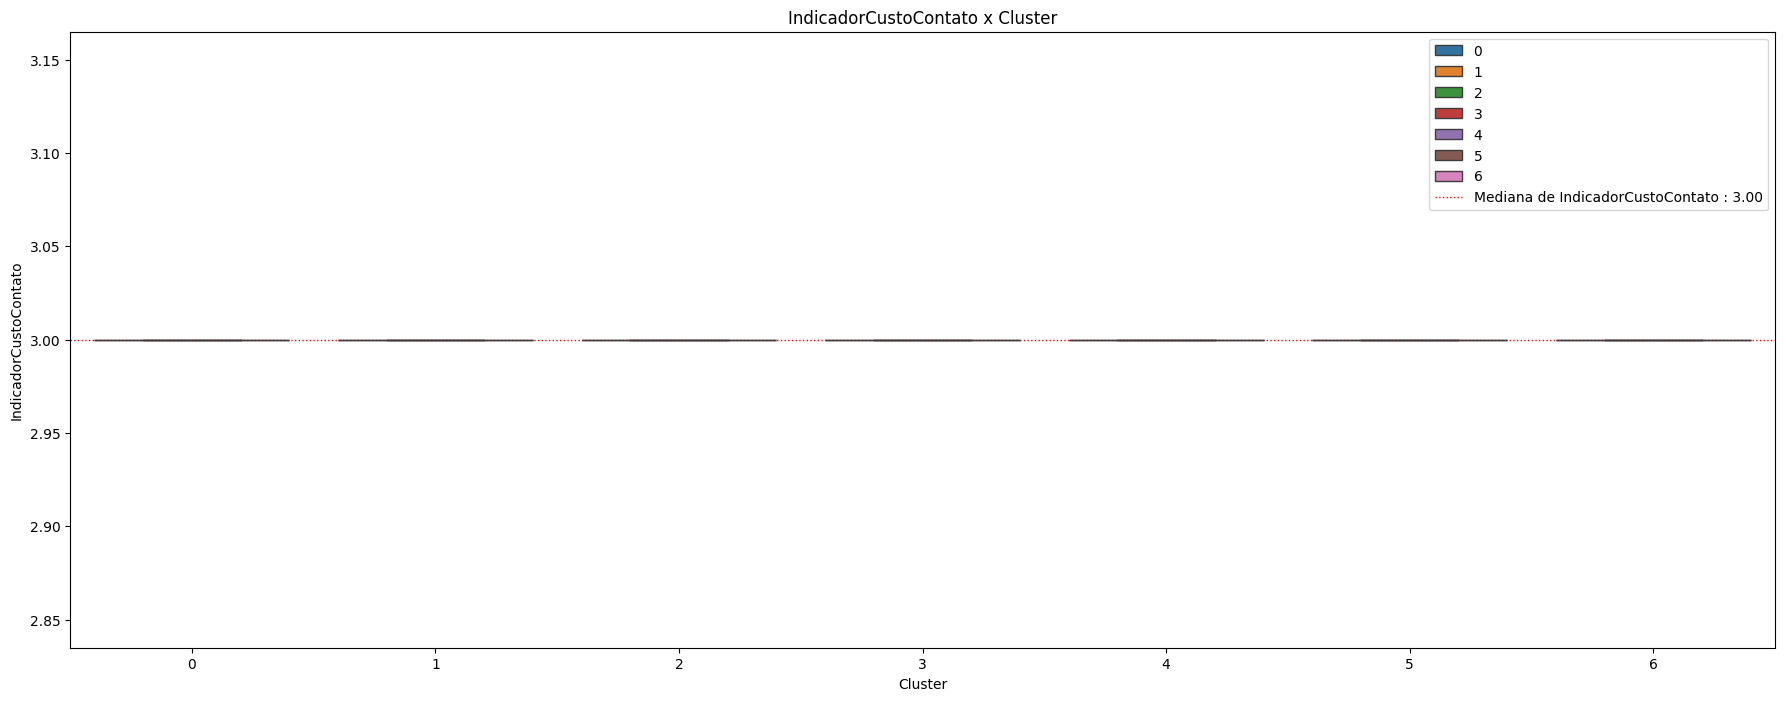

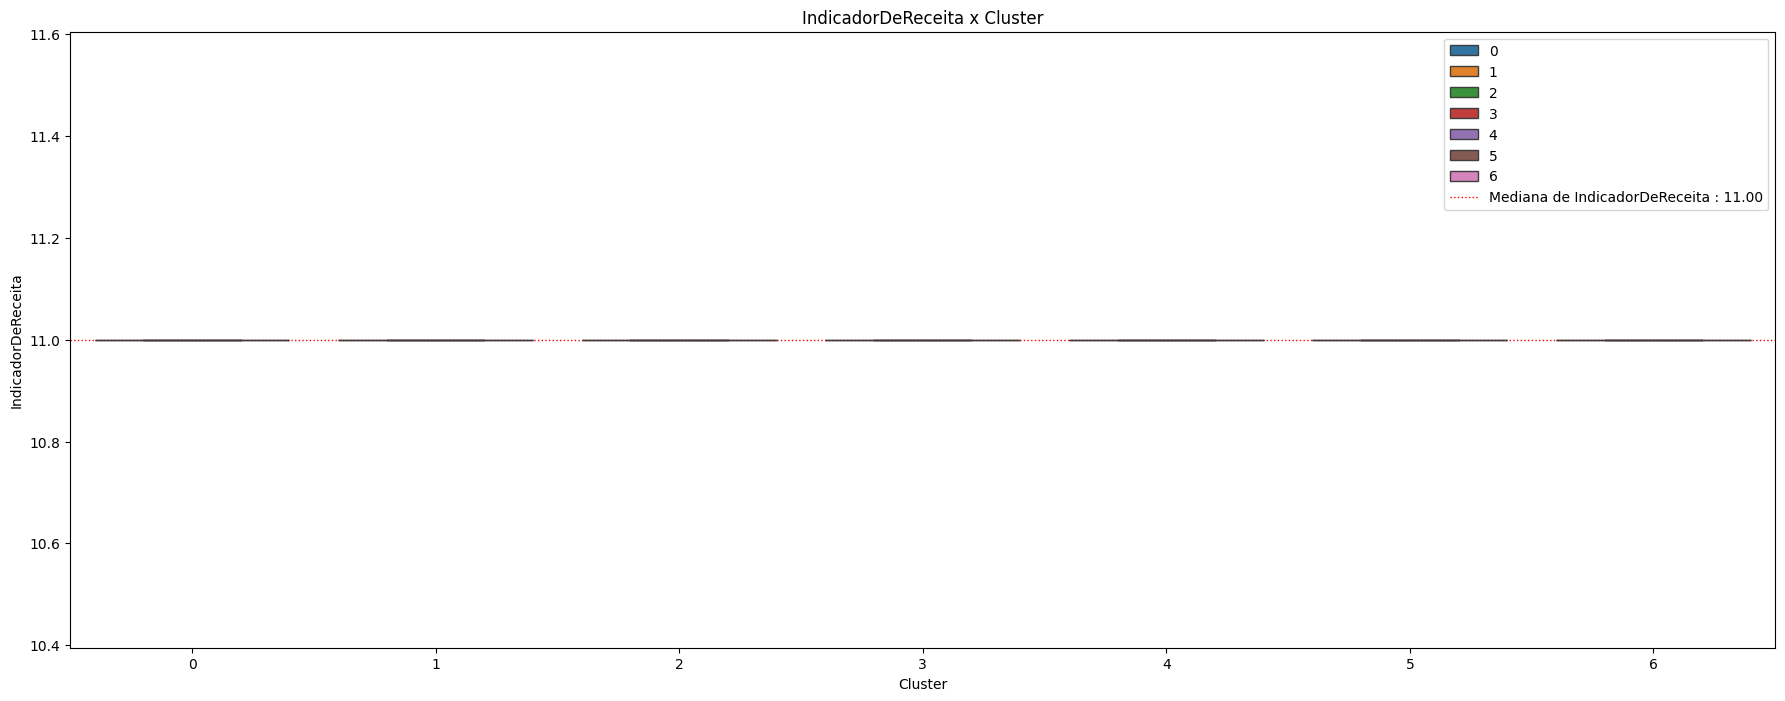

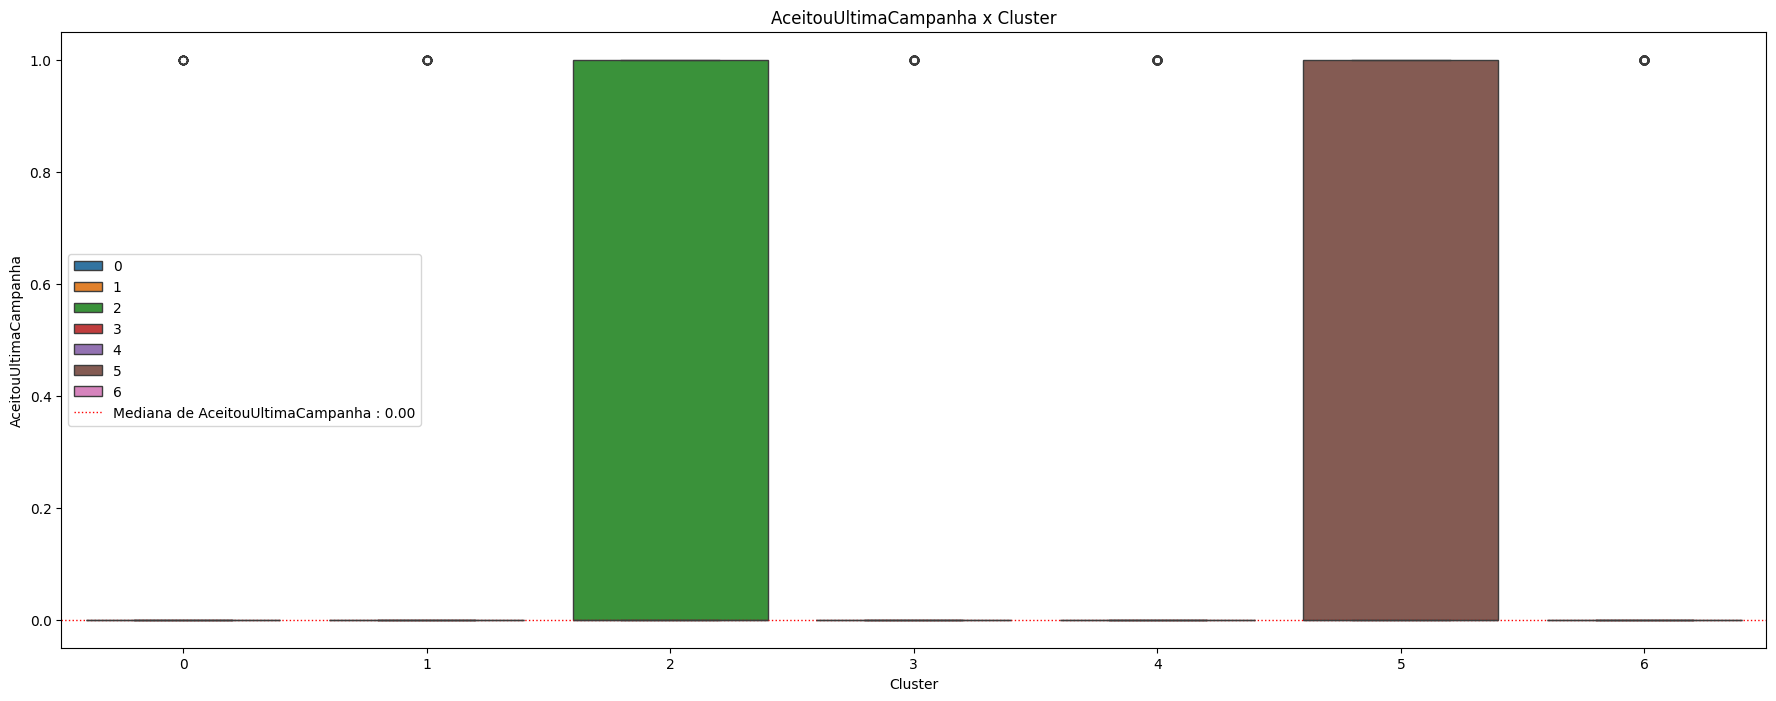

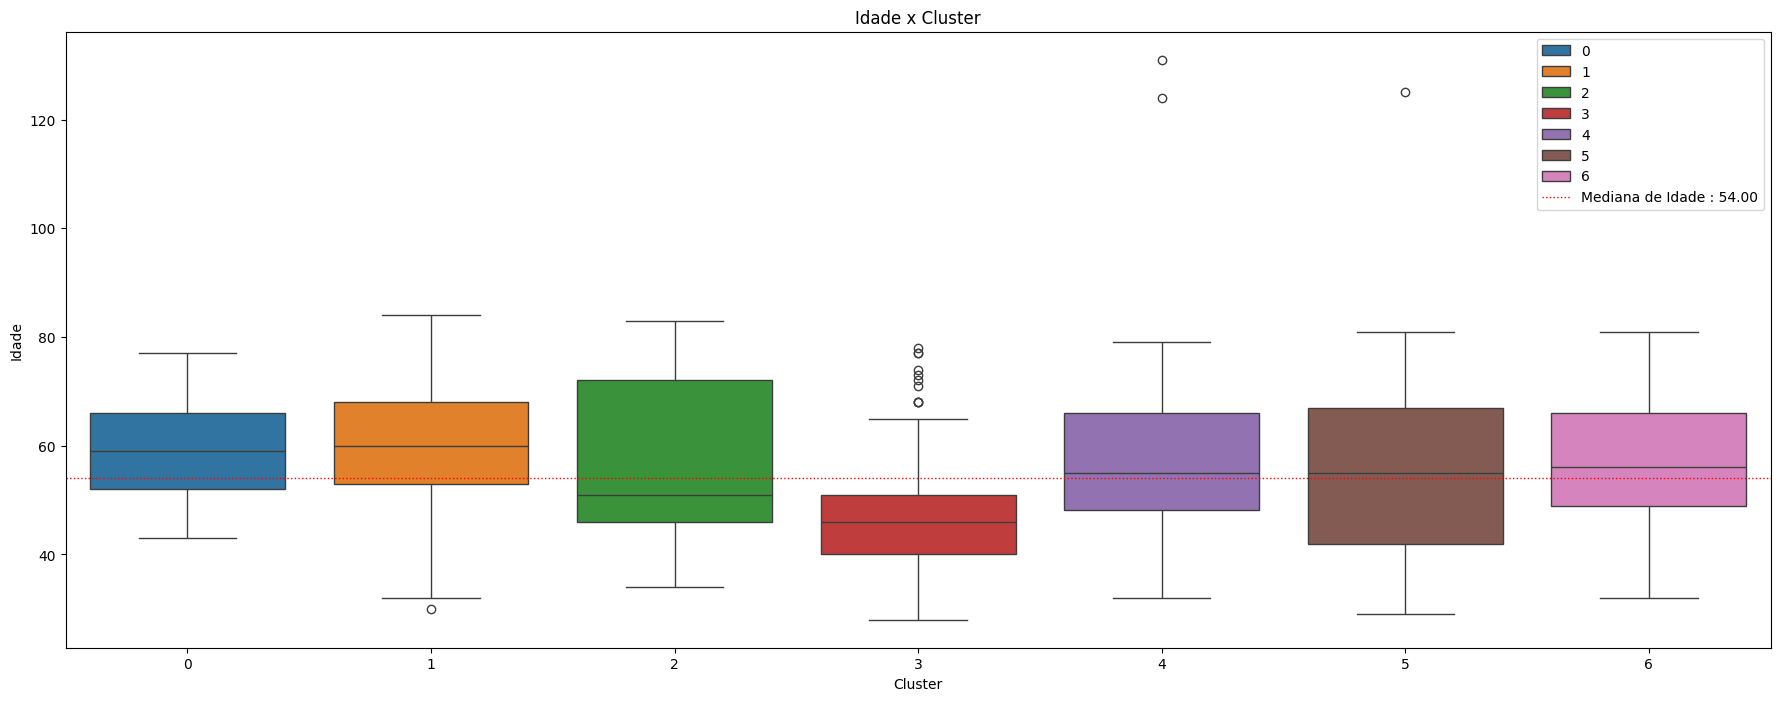

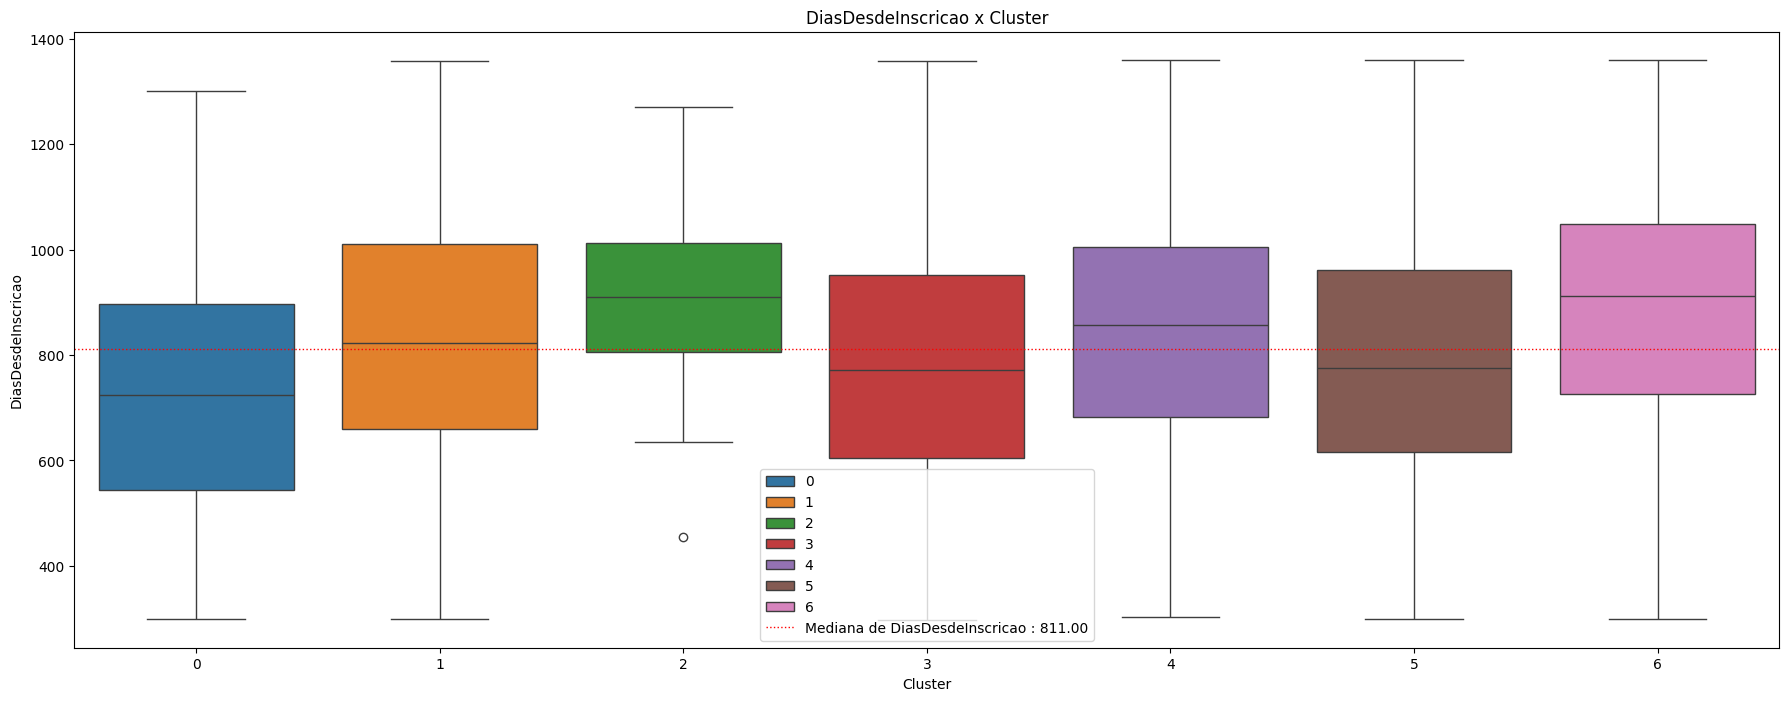

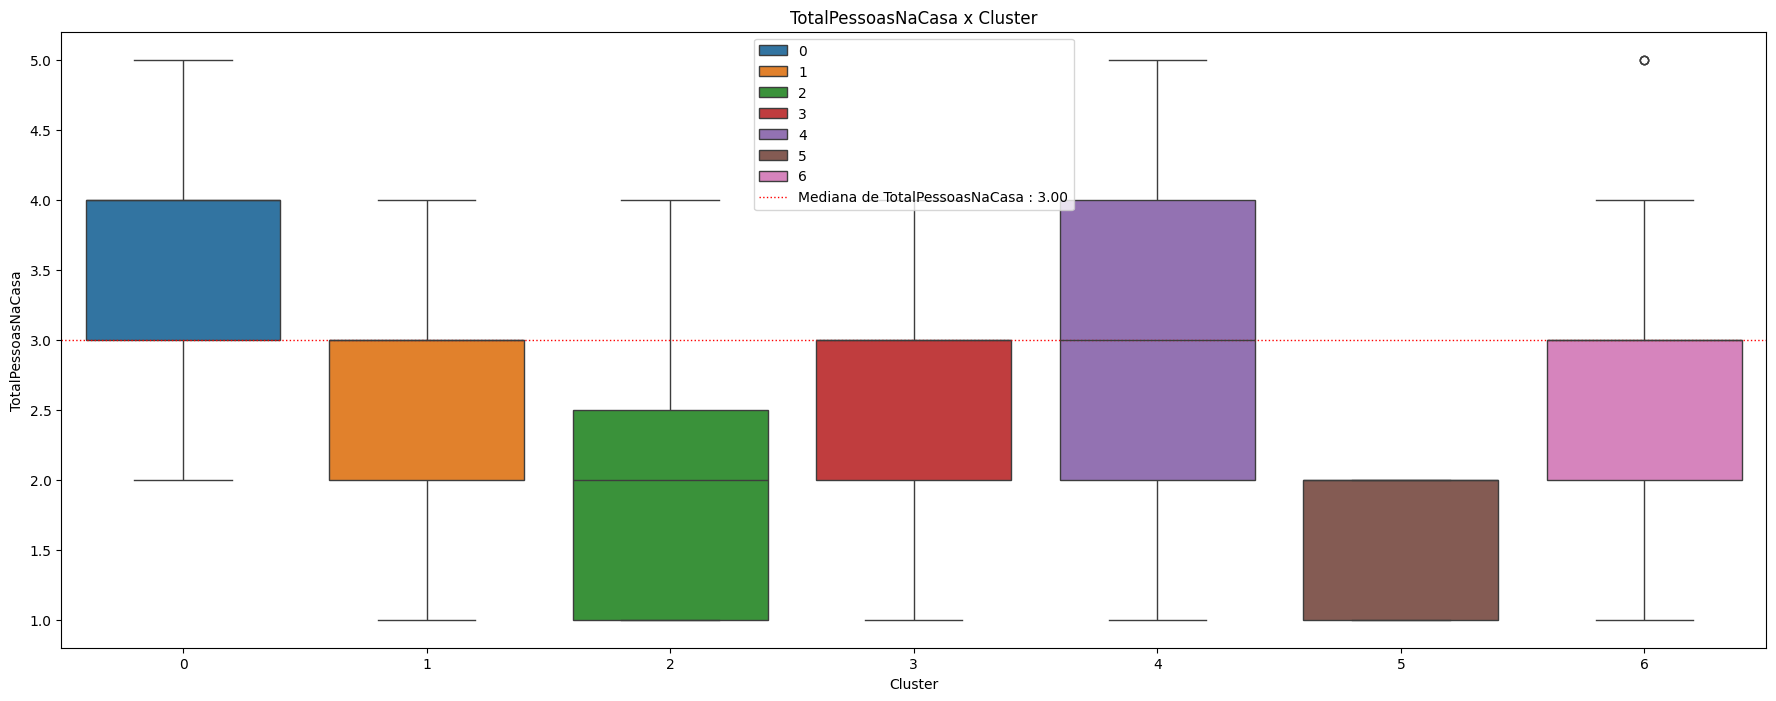

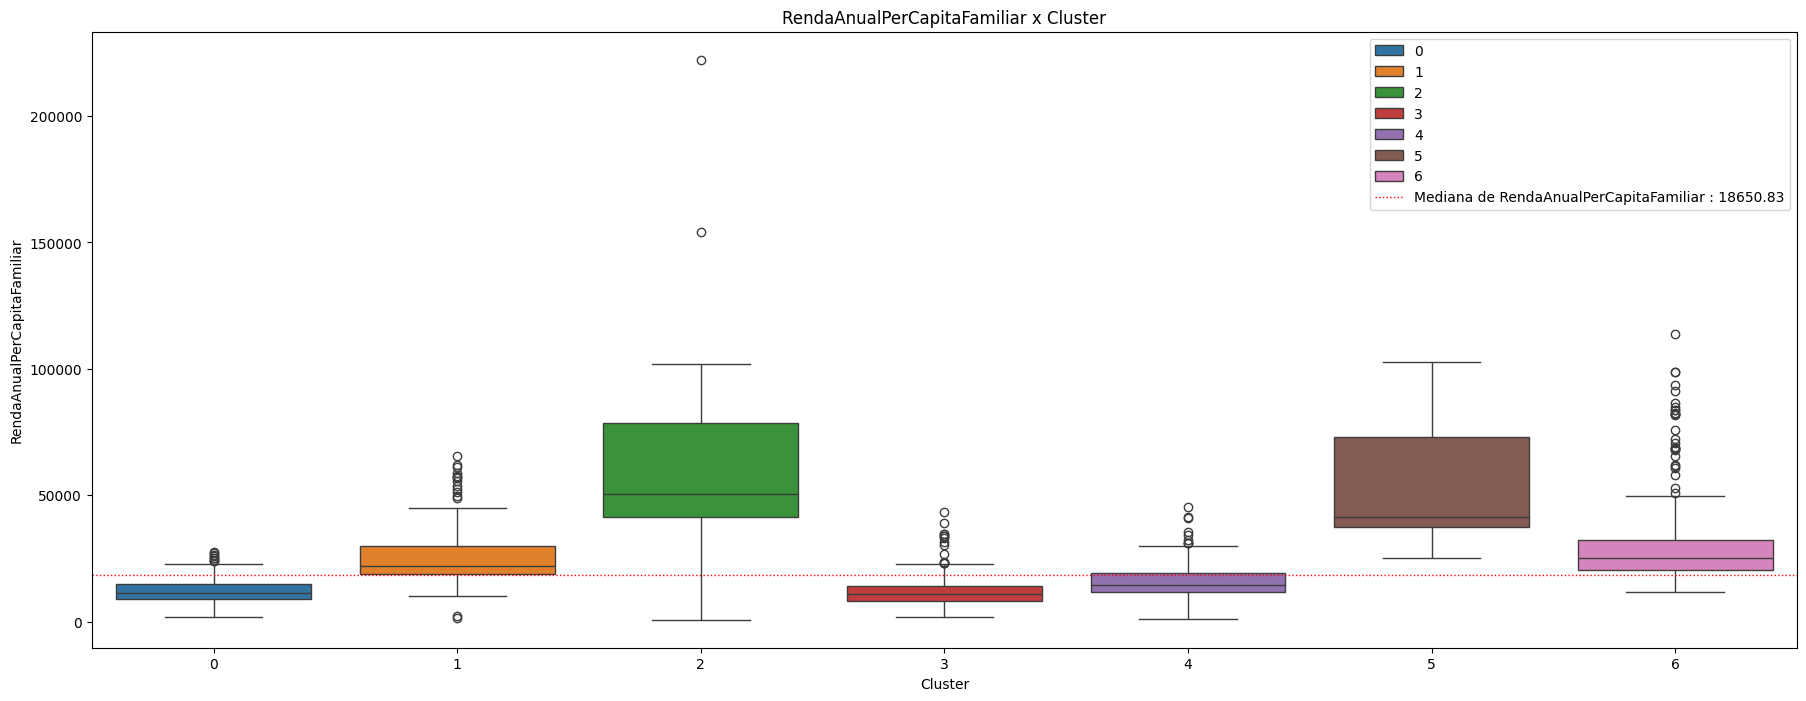

In [ ]:
vars2 = list(num_attributes.columns).copy()

vars_numericas = vars2

for var in vars_numericas:
  plt.figure(figsize=(22, 8))
  pl=sns.boxplot(x=df_publico["Cluster"], y=df_publico[var], palette= pal, hue=df_publico["Cluster"])

  mediana = df_publico[var].median()
  # Adicionando uma linha indicando a média da variável de aceitacao
  text = f'Mediana de {var} :'+' {:.2f}'.format(mediana)
  plt.axhline(mediana, color='red', linestyle='dotted', linewidth=1, label=text)

  pl.set_title(f"{var} x Cluster")
  plt.legend()
  plt.show()

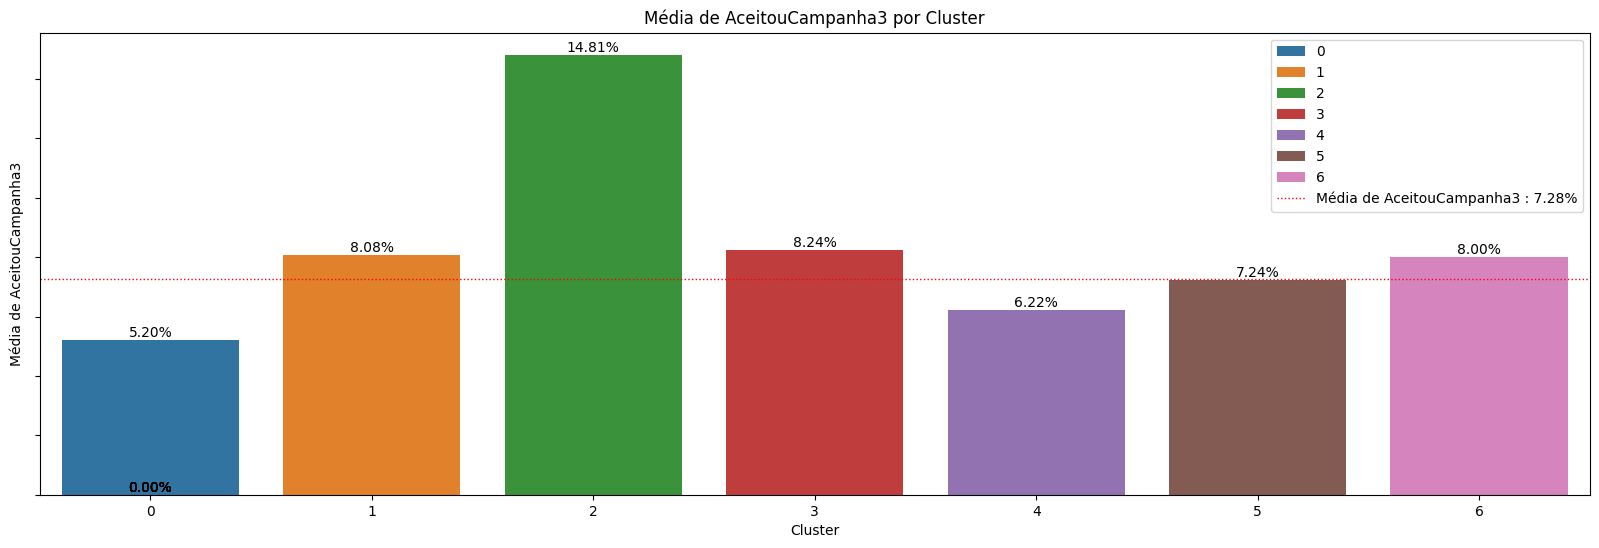

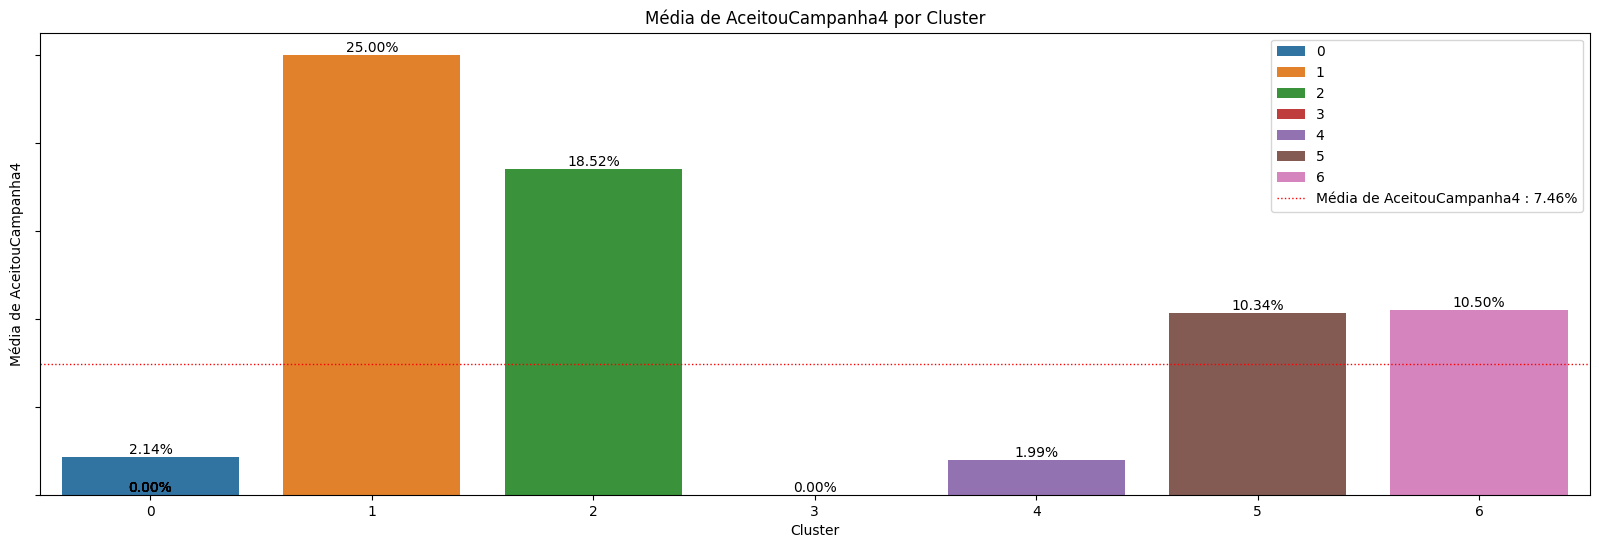

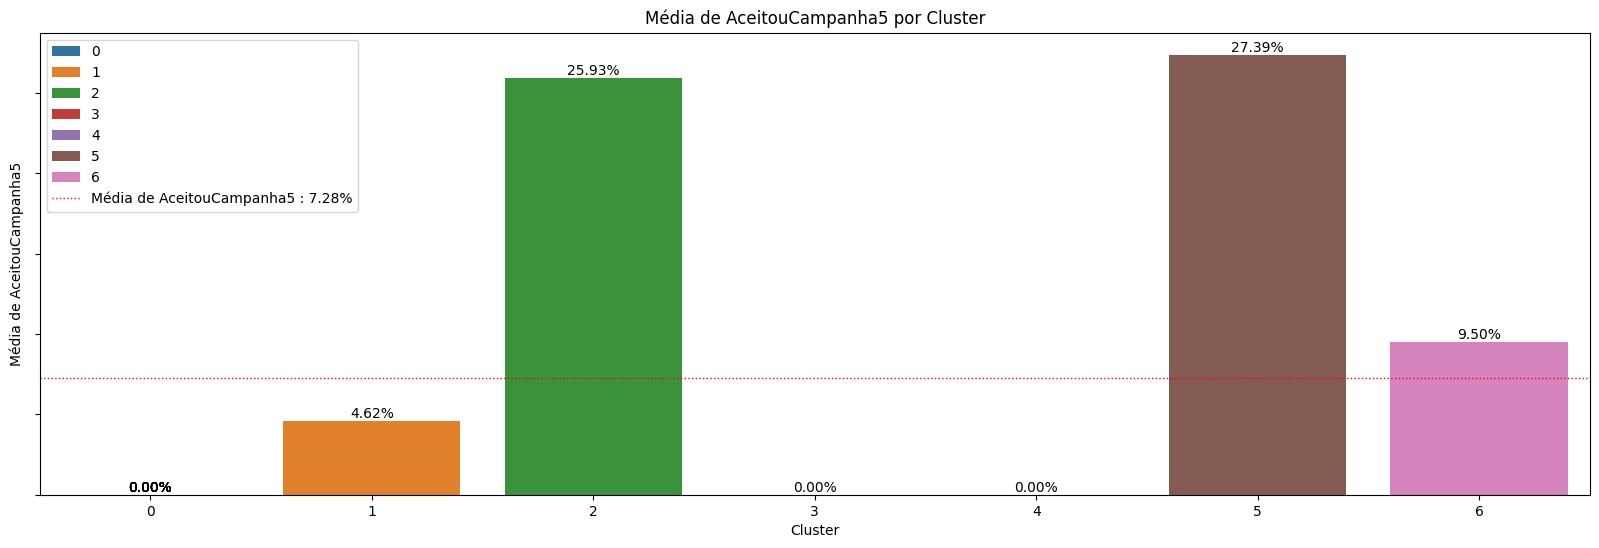

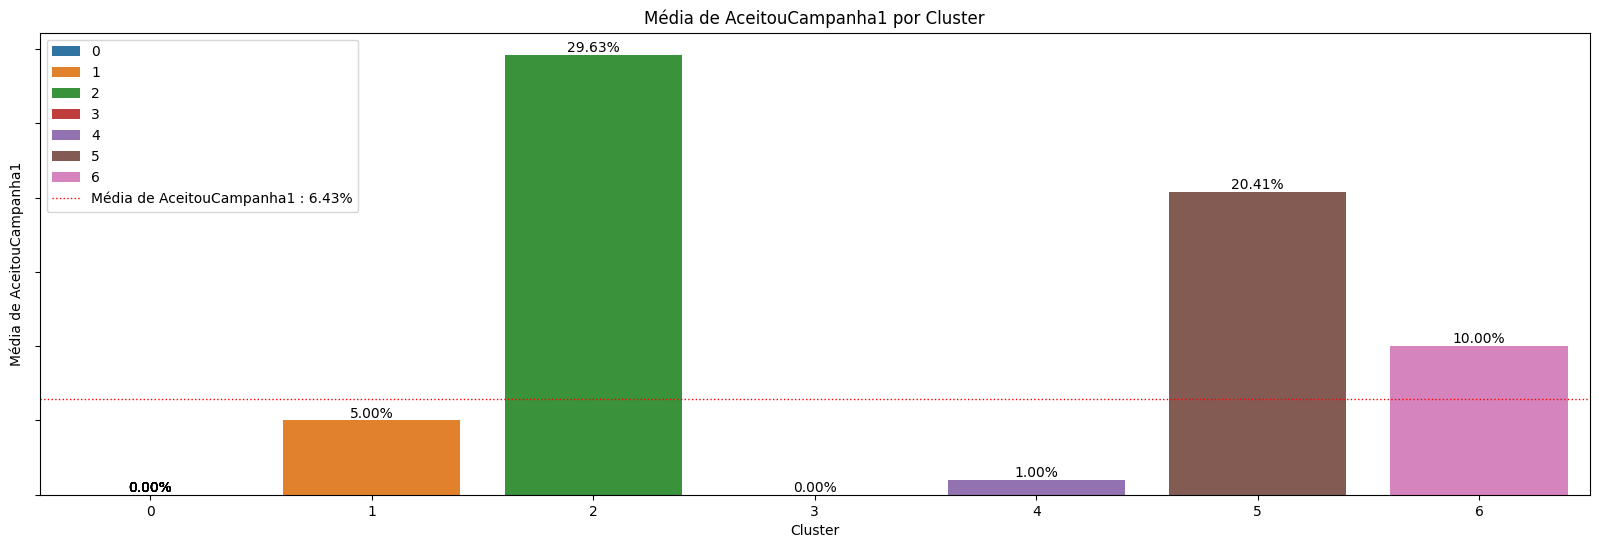

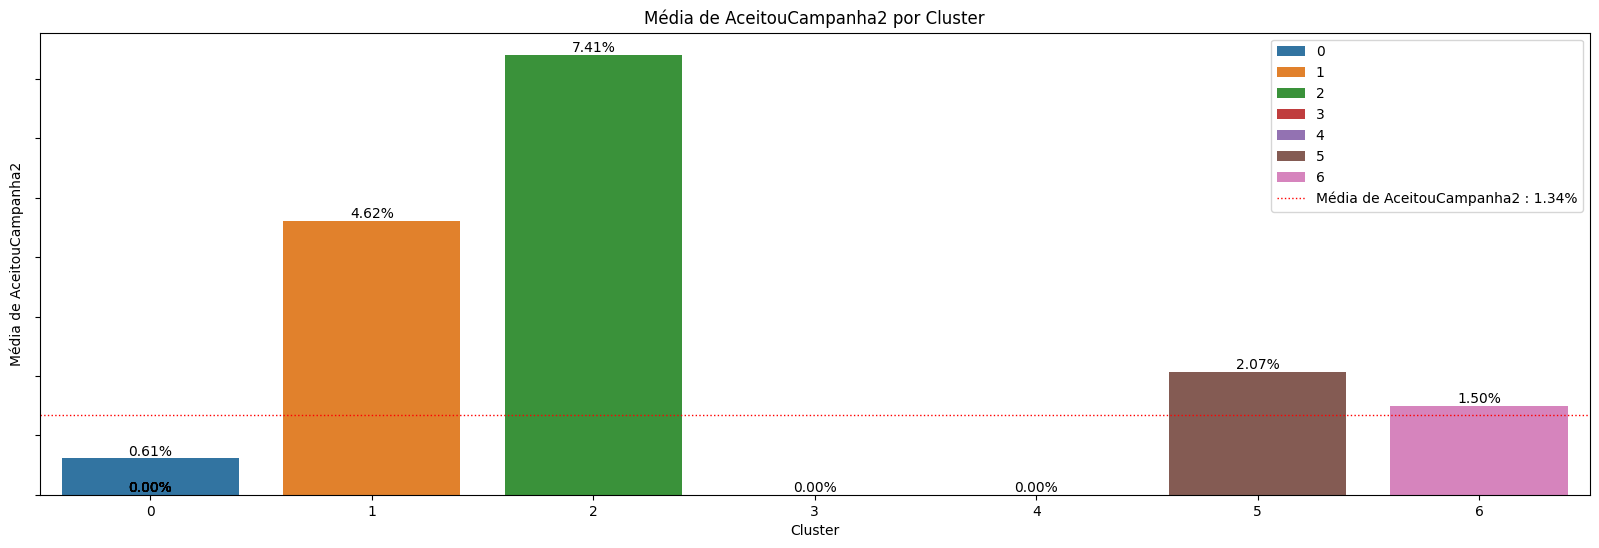

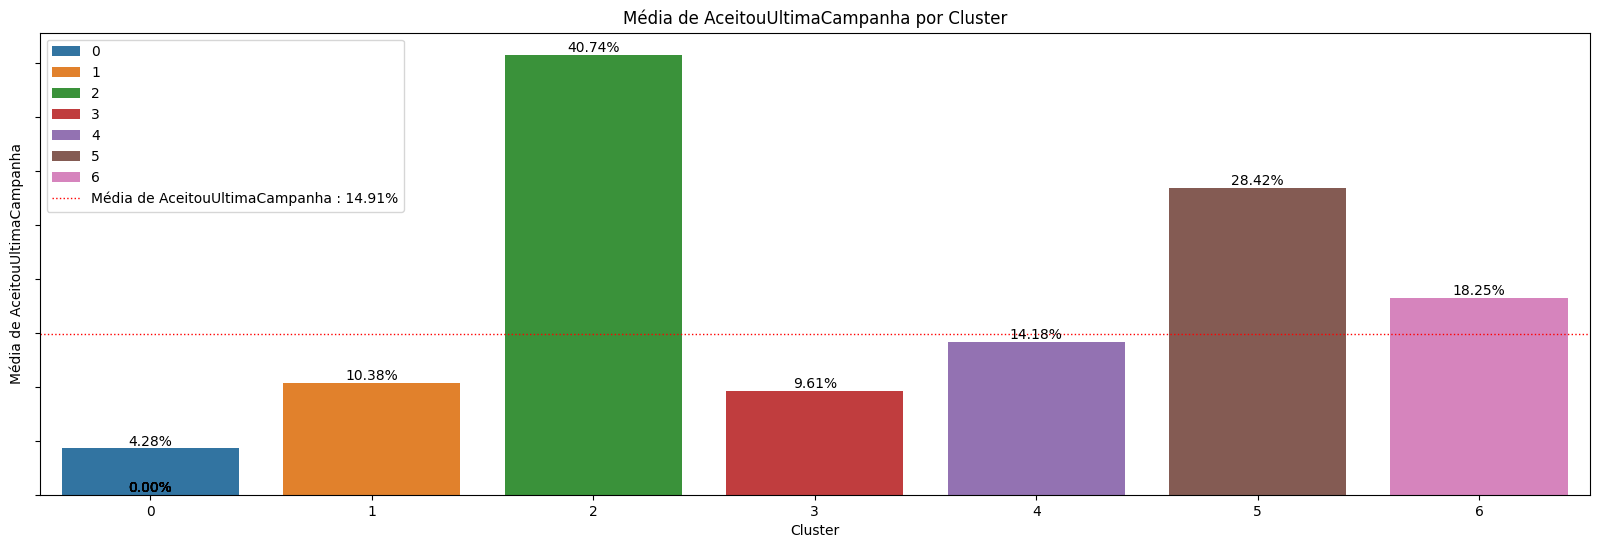

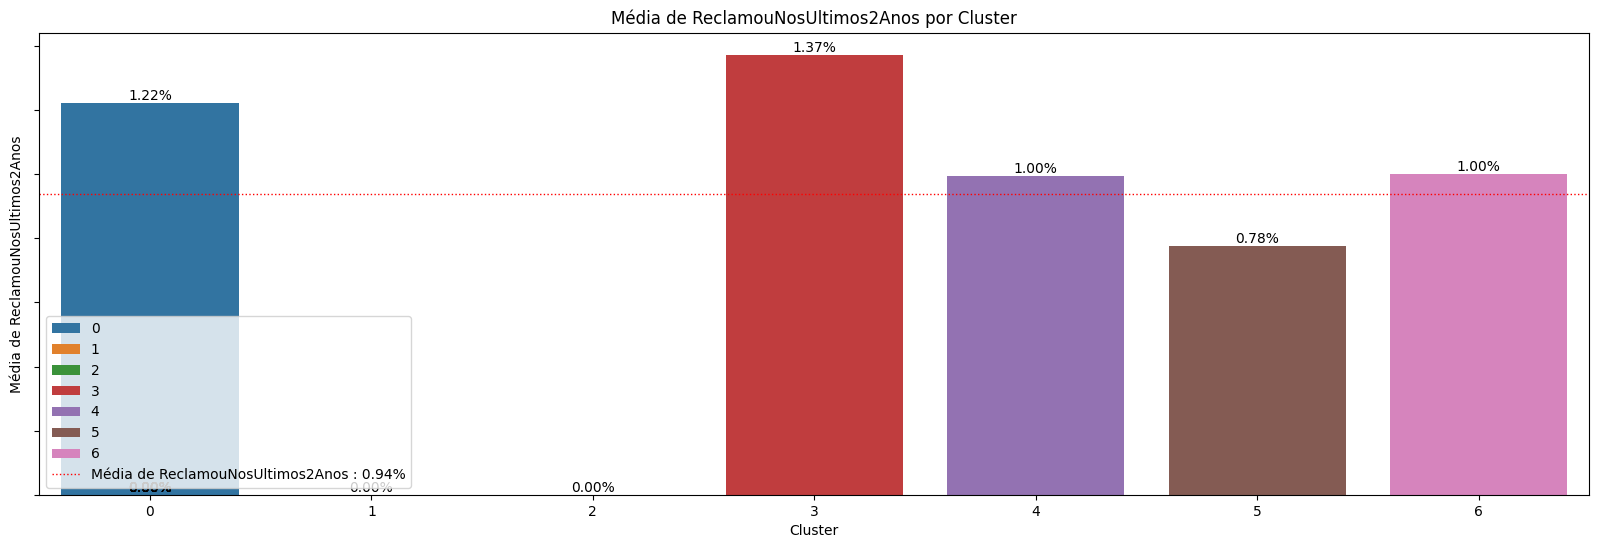

In [ ]:
filtered_vars = [var for var in vars2 if 'AceitouCampanha' in var or 'AceitouUltimaCampanha' in var or 'AceitouUltimaCampanha' in var]
filtered_vars.append('ReclamouNosUltimos2Anos')

for var in filtered_vars:
    plt.figure(figsize=(20, 6))
    ax = sns.barplot(data=df_publico, x='Cluster', y=var, estimator='mean', errorbar=None, palette= pal, hue='Cluster')
    plt.title(f"Média de {var} por Cluster")
    plt.xlabel('Cluster')
    plt.ylabel(f'Média de {var}')

    media = df_publico[var].mean()
    # Adicionando uma linha indicando a média da variável de aceitacao
    text = f'Média de {var} :'+' {:.2f}%'.format(100*media)
    plt.axhline(media, color='red', linestyle='dotted', linewidth=1, label=text)

    # Adicionando os valores no topo de cada barra
    for p in ax.patches:
        ax.annotate(f'{100*p.get_height():.2f}%',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    fontsize=10, color='black',
                    xytext=(0, 5),
                    textcoords='offset points')
    plt.gca().axes.yaxis.set_ticklabels([])
    plt.legend()
    plt.show()

### Insights Gerados:

- **Renda Anual Familiar**:
  - A renda anual familiar dos clientes no Cluster 5 está totalmente acima da mediana, enquanto no Cluster 6, a maior concentração também se encontra acima da mediana.

- **Quantidade de Crianças na Casa**:
  - Tanto o Cluster 5 quanto o Cluster 6 apresentam uma mediana de 0 crianças. Contudo, no Cluster 6, há outliers com uma criança na casa.

- **Quantidade de Adolescentes na Casa**:
  - O Cluster 5 não apresenta adolescentes na casa. Já o Cluster 6 possui uma grande concentração de casas com 1 adolescente, podendo chegar a até 2 adolescentes por casa.

- **Dias Desde a Última Compra**:
  - Todos os clusters estão próximos à mediana geral.

- **Gasto com Vinho nos Últimos 2 Anos**:
  - Nos Clusters 5 e 6, a maior concentração de gastos está acima da mediana, com outliers superando 1400 unidades monetárias em vinhos.

- **Gasto com Frutas nos Últimos 2 Anos**:
  - Nos Clusters 5 e 6, os gastos com frutas estão majoritariamente acima da mediana, apresentando um consumo superior ao dos demais clusters.

- **Gasto com Carne nos Últimos 2 Anos**:
  - No Cluster 5, os gastos com carne estão sempre acima ou igual à mediana, enquanto no Cluster 6, a maior concentração também se encontra acima da mediana.

- **Gasto com Peixe nos Últimos 2 Anos**:
  - Ambos os clusters, 5 e 6, têm sua maior concentração de gastos com peixes acima da mediana.

- **Gasto com Doces nos Últimos 2 Anos**:
  - Os Clusters 5 e 6 também apresentam maior concentração de gastos com doces acima da mediana.

- **Gasto com Ouro nos Últimos 2 Anos**:
  - Os gastos com ouro nos Clusters 5 e 6 estão concentrados acima da mediana.

- **Compras com Desconto**:
  - O Cluster 5 não realiza compras com desconto, enquanto no Cluster 6 esse comportamento é mais dividido entre quem compra e quem não compra com desconto.

- **Compras no Website**:
  - A maior parte do Cluster 6 realiza compras no website, enquanto no Cluster 5 esse comportamento também ocorre, mas com menor frequência.

- **Compras por Catálogo**:
  - No Cluster 5, as compras por catálogo estão sempre iguais ou superiores à mediana, enquanto no Cluster 6, há uma grande concentração de consumidores nesse tipo de compra.

- **Compras na Loja**:
  - A maior concentração de compras na loja está acima da mediana em ambos os clusters.

- **Visitas ao Site no Último Mês**:
  - No Cluster 5, quase todas as visitas ao site estão abaixo da mediana, com alguns outliers. No Cluster 6, uma parte do público está acima da mediana.

- **Aceitou Campanha 3**:
  - O Cluster 6 tem uma taxa de aceitação de 8,00%, enquanto o Cluster 5 apresenta 7,24%, ambas ligeiramente abaixo da média de 7,28%.

- **Aceitou Campanha 4**:
  - O Cluster 5 apresenta uma taxa de aceitação de 10,34%, enquanto o Cluster 6 tem 10,50%. Ambos estão acima da média de 7,46%.

- **Aceitou Campanha 5**:
  - O Cluster 5 apresenta a maior taxa de aceitação entre todos os clusters, com 27,39%. Já o Cluster 6 apresenta uma taxa de 9,50%. Ambos estão acima da média de 7,28%.

- **Aceitou Campanha 1**:
  - O Cluster 5 apresenta uma taxa de aceitação de 20,41%, enquanto o Cluster 6 apresenta 10,00%. Ambos estão acima da média de 6,43%.

- **Aceitou Campanha 2**:
  - O Cluster 5 apresenta uma taxa de aceitação de 2,07%, enquanto o Cluster 6 tem 1,50%. Ambas estão acima da média de 1,34%.

- **Reclamou nos Últimos 2 Anos**:
  - O Cluster 5 tem uma taxa de reclamação de 0,78%, abaixo da média de 0,94%, enquanto o Cluster 6 apresenta uma taxa de 1,00%.

- **Aceitou Última Campanha**:
  - O Cluster 5 apresenta uma taxa de aceitação de 28,42%, enquanto o Cluster 6 tem 18,25%. Ambos estão acima da média de 14,91%.

- **Idade**:
  - Os Clusters 5 e 6 apresentam comportamento semelhante, com a concentração de idades dividida entre abaixo e acima da mediana.

- **Dias Desde a Inscrição**:
  - No Cluster 5, pouco mais da metade dos clientes está abaixo da mediana, enquanto no Cluster 6, a maior concentração está acima da mediana.

- **Total de Pessoas na Casa**:
  - No Cluster 5, a concentração é de até 2 pessoas por casa, abaixo da mediana. No Cluster 6, há um grande volume entre 2 e 3 pessoas, com uma concentração de 4 pessoas e um outlier de 5 pessoas na casa.

- **Renda Anual Per Capita Familiar**:
  - O Cluster 5 está completamente acima da mediana, e no Cluster 6, a maior concentração também está acima da mediana.


# Considerações Finais

Principais insights:

Os clusters com maior taxa de aceitação geral são os clusters 5 e 6.

As principais características do Cluster 5 são:

**Perfil familiar**:
- A maioria das residências é composta por até 2 pessoas.
- A renda anual familiar está completamente acima da mediana geral, demonstrando um poder aquisitivo elevado.

**Gastos**:
- **Oportunidade em Carne e Vinhos**: O Cluster 5 apresenta gastos consistentemente elevados com carne e vinhos, sendo uma oportunidade para campanhas promocionais focadas nesses produtos.
- **Frutas e Peixes**: O consumo de frutas e peixes também está acima da mediana, o que sugere potencial para ações voltadas a alimentos saudáveis.
- **Doces**: Apesar dos gastos com doces estarem abaixo da mediana, é possível explorar esse nicho com ofertas específicas para aumentar o consumo.

**Compras**:
- O Cluster 5 realiza mais compras por catálogo, além de compras online e na loja física acima da mediana. Investir em marketing multicanal pode ser uma estratégia eficaz.
- Esse grupo não faz compras com desconto, indicando um público que valoriza mais a qualidade do que o preço.

**Taxas de aceitação de campanhas**:
- **Campanha 3**: 7,24%.
- **Campanha 4**: 10,34%.
- **Campanha 5**: 27,39%.
- **Última campanha**: 28,42%.

**Demografia**:
- O Cluster 5 apresenta uma mediana de idade distribuída entre abaixo e acima da mediana geral.
- Mais da metade dos clientes possuem dias desde a inscrição abaixo da mediana.

---

As principais características do Cluster 6 são:

**Perfil familiar**:
- Residências com 2 a 3 pessoas, com uma concentração de famílias com até 4 pessoas. Existem outliers de casas com 5 pessoas.
- Renda familiar per capita acima da mediana geral, refletindo um nível socioeconômico mais alto.

**Gastos**:
- **Carne e Vinhos**: Assim como no Cluster 5, há um gasto elevado com carne e vinhos, sendo relevante reforçar campanhas relacionadas a esses produtos.
- **Frutas e Peixes**: Gasto com frutas e peixes acima da mediana, refletindo hábitos de consumo focados em alimentação mais saudável.
- **Oportunidade em Doces**: O Cluster 6 tem um consumo relevante de doces, representando uma oportunidade para incrementar ofertas direcionadas a esses produtos.

**Compras**:
- O Cluster 6 realiza a maior parte de suas compras no website, o que sinaliza uma oportunidade para aprimorar as campanhas de e-commerce.
- O comportamento de compras com desconto é dividido, sugerindo ações que combinem promoções e vantagens exclusivas.

**Taxas de aceitação de campanhas**:
- **Campanha 3**: 8,00%.
- **Campanha 4**: 10,50%.
- **Campanha 5**: 9,50%.
- **Última campanha**: 18,25%.

**Demografia**:
- O Cluster 6 tem uma idade distribuída de forma semelhante ao Cluster 5, com parte da concentração acima da mediana e parte abaixo.
- A maioria dos clientes possui dias desde a inscrição acima da mediana, sugerindo uma fidelização maior.
